# Belief Propagation from Geo-Located Imagery

In [1]:
# If new server on Descartes Labs, need to install rioxarray 
try: import rioxarray
except: 
    %pip install rioxarray

import demo_functions as df

__________
Let's begin with the input parameters. These include the label file, confidence in the labels and the data types we will use. Once we confirm the data types we will be asked for paths to the files containing the imagery. Post-event must be provided but pre-event is optional. If a pre-event image is provided the data used will be the difference between the images which contains more information than the post event image alone.

In [2]:
inputs = df.parameter_input()

HTML(value='<b>Label Parameters</b>')

Box(children=(Label(value='Damage Labels: Shapefile - '), Text(value='./data/beirutDamages.shp', layout=Layout…

Box(children=(Label(value='Label Confidence ($P_{other label}$, $P_{class}$)'), FloatRangeSlider(value=(0.0, 1…

HTML(value='<b>Map Properties</b>')

Box(children=(Label(value='Latitude - '), FloatText(value=33.893, layout=Layout(width='max-content')), Label(v…

HTML(value='<b>Data Parameters</b>')

Box(children=(Label(value='Enter Data Types:'), Combobox(value='HighRes Imagery', layout=Layout(width='max-con…

______
Now let's load up the map of our ground labels and define an area for the model. Then below the map we'll pick the model parameter to run on the data from the selected area. If we wish to group classes together we will also be offered some clustering options.

In [3]:
parameters = df.model_parameters(inputs)

Map(center=[33.893, 35.512], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

HTML(value='<h3>Model Parameters</h3>')

HTML(value='<b>Node Properties</b>')

Box(children=(Label(value='Max nodes - Sampling occurs if < pixel number:'), IntText(value=20000, layout=Layou…

HTML(value='<b>Edge Properties</b>')

Box(children=(Label(value='Neighbours - Edges to nearest values for each node: '), Box(children=(IntText(value…

Box(children=(Label(value='Geographical Edges - '), Checkbox(value=False, indent=False, layout=Layout(width='m…

HTML(value='<b>Class Properties</b>')

HTML(value="Label Classes - ['GREEN' 'YELLOW' 'LAND' 'RED' 'TOTAL']")

Box(children=(Label(value='Classes for Model - '), Dropdown(index=3, options=(2, 3, 4, 5), value=5)))

________
Now we have all the parameters for the model, let's import and classify the data according to our selections. If you have already imported the data and just adjusted the model parameters then just re-classify rather than re-importing.

In [56]:
import helper_functions as hf
import imports as ip
import demo_functions as demo

def import_data(v):
    # Retrieve file locations from inputs
    for j in range(len(v['dataTypes'])):
        try: v['preFile'+str(j)], v['postFile'+str(j)] = [i.value for i in v['bxfile'+str(j)].trait_values()['children'][1::2]]    
        except KeyError: raise KeyError('Please make sure you have confirmed the data types.')
    for i in v.keys(): globals()[i] = v[i] # Retrieve variables to use
   
    # Reproject Data if necessary
    v = demo.reproject_data(v)
    
    # Import Files
    print("------Importing Data Files---------")
    # Import first data type
    df, crop = ip.img_to_df(postFile0, testPoly, crs=crs)
    if preFile0:
        preDf, _ = ip.img_to_df(preFile0, testPoly, crs=crs)
        df -= preDf

    # Import other data types
    if len(dataTypes) > 1:
        crop.rio.to_raster("croptemp.tif")
        for i in range(1, len(dataTypes)):
            ip.resample_tif(globals()['postFile'+str(i)], testPoly, 'posttemp'+str(i)+'.tif')
            globals()['dataArray'+str(i)] = ip.tif_to_array('posttemp'+str(i)+'.tif', 'resample')
            if globals()['preFile'+str(i)]: 
                ip.resample_tif(globals()['preFile'+str(i)], testPoly, 'pretemp'+str(i)+'.tif')
                globals()['dataArray'+str(i)] -= ip.tif_to_array('pretemp'+str(i)+'.tif', 'resample')
        ip.del_file_endings(".", "temp*.tif")

    # Concatenate data types
    data = df.copy()
    for j in range(1, len(dataTypes)): 
        da = globals()['dataArray'+str(1)]
        for k in range(min(da.shape)):
            data[str(dataTypes[j])+str(k)]=da.reshape(min(da.shape),-1)[k]
    data.dropna(inplace=True)
    print("------Finished Data Import---------")
    typesUsed = [list(df.columns.values)]
    for j in range(1,len(dataTypes)): typesUsed.append(list(data.columns[[dataTypes[j] in str(i) for i in data.columns]]))
    
    v.update({'data':data, 'typesUsed':typesUsed})
    return v

import os
import random
import importlib
import ground_truth
import numpy as np
import pandas as pd
import rasterio as ro
import rioxarray as rxr
import geopandas as gpd
import helper_functions as hf
import shapely.geometry as sg
from rasterio.io import MemoryFile
from rasterio.enums import Resampling
from rasterio.windows import from_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling

def img_to_df(file, poly=False, crs=False, label='img', columns=False, crsPoly='epsg:4326', verbose=True):
    # Import raster
    img = rxr.open_rasterio(file, masked=True).squeeze()
    
    # Crop image if polygon supplied
    if poly:
        _, extent = hf.get_extent(poly, crsPoly=crsPoly, crs=crs)
        img = img.rio.clip(extent.geometry.apply(sg.mapping))   
    named = img.rename('img')
    
    # Convert to dataframe
    xm, ym = np.meshgrid(np.array(named.coords['x']), np.array(named.coords['y']))
    mi = pd.MultiIndex.from_arrays([ym.flatten(),xm.flatten()],names=('y','x'))
    size = min(named.shape) if len(named.shape) > 2 else 1 
    df = pd.DataFrame(named.data.reshape(size,-1).transpose(), index=mi)
    if verbose: print(file+" read completed.")
    
    return df, named
  

In [10]:
imports = import_data(parameters)

------Checking Coordinate Systems-------
------Finished Checking Coordinate Systems-------
------Importing Data Files---------
data/highRes/20AUG05_HR_LatLon.tif read completed.
data/highRes/20JUL31_HR_LatLon.tif read completed.


/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  coro.send(None)


./data/beirutPrePostExplosionIfg.tif read completed.
./data/beirutPrePreExplosionIfg.tif read completed.
------Finished Data Import---------


In [43]:
classified = classify_data(imports)

------Data Sampling---------
------Data Classification---------
------Finished Data Classification---------


____________
OK, the data is formatted the model parameters are all checked. Let's build the graph of nodes & edges and run the belief propagation!

In [44]:
for i in classified.keys(): globals()[i] = classified[i]
initial = classified['initial']
trainSplit = bxNodes.trait_values()['children'][3].value
confidence = list(bxConf.trait_values()['children'][1].value)
neighbours = [i.value for i in bxEdges.trait_values()['children'][1].trait_values()['children']]
adjacent, geoNeighbours = [i.value for i in bxAdjacent.trait_values()['children'][1::2]]

# Split pixels in to train and test sets    
X_train, X_test, y_train, y_test = hf.train_test_split(labelsUsed, cn, hf.get_polygon(testPoly, conv=True), testSplit=(1-(trainSplit/100)))

# Create nodes
nodes = hf.create_nodes(initial, X_train)

import numpy as np
summary = nodes.groupby(cn).size()
equivUse = True
if equivUse:
    equiv = gpd.GeoDataFrame()
    for i in summary.index.values:
        equiv = equiv.append(nodes[nodes[cn] == i][0:min(summary)])
    equiv = equiv.append(nodes[[np.isnan(x) for x in nodes[cn]]])
    nodes=equiv.copy()
    initial = initial.loc[nodes.index.values].reset_index()

# Assign prior beliefs from assessments
priors = hf.prior_beliefs(nodes, beliefColumns = initial.columns[-nClasses:], beliefs=confidence, classNames=classNames, column = cn)

classes =  classNames
d = dict(enumerate(classes))

gdf = gpd.sjoin(initial, X_test, how='left', op='within').dropna(subset=[cn])
summary = gdf.groupby(cn).size()
equivTest = True
if equivTest:
    equiv = gpd.GeoDataFrame()
    for i in summary.index.values:
        equiv = equiv.append(gdf[gdf[cn] == i][0:min(summary)])
    equiv = equiv.append(gdf[[np.isnan(x) for x in gdf[cn]]])
    y_true = equiv[cn]
    y_true_l = list(equiv[cn])
else: y_true = gdf[cn]

In [45]:
import sklearn as skl
import numpy as np
# Edge creation
measures = [0,0,0,0,0,0,0]
from tqdm import tqdm
scores = []
num = 11
for geoNeighbours in tqdm(range(num)):
    for ed1 in tqdm(range(num)):
        for ed2 in tqdm(range(num)):
            neighbours = [ed1,ed2]
            if all(values is 0 for values in neighbours) and (geoNeighbours is 0):
                edges, beliefs = [], priors
            else:                    
                edges = hf.create_edges(nodes, adjacent=adjacent, geo_neighbours=geoNeighbours, values=typesUsed, neighbours=neighbours)
                beliefs, _ = nc.netconf(edges,priors,verbose=False,limit=1e-3)

            # Get y_true vs y_pred for test set
            y_pred = skl.preprocessing.normalize(beliefs[y_true.index], norm='l1')
            yp_clf = np.argmax(y_pred, axis=1)                
            pred_clf = [i for i in yp_clf]
            f1 = skl.metrics.f1_score(y_true_l, pred_clf,average='weighted',zero_division=0)
            a = skl.metrics.accuracy_score(y_true_l, pred_clf)
            r = skl.metrics.recall_score(y_true_l, pred_clf,average='weighted',zero_division=0)
            log_loss = skl.metrics.log_loss(y_true_l, y_pred, labels=[0,1])
            measures = np.vstack((measures, [geoNeighbours, ed1, ed2, f1,a,r,log_loss]))

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:03<00:13,  1.51s/it]

14  iterations




 27%|██▋       | 3/11 [00:07<00:23,  2.88s/it]

9  iterations




 36%|███▋      | 4/11 [00:10<00:20,  2.92s/it]

9  iterations




 45%|████▌     | 5/11 [00:13<00:16,  2.82s/it]

9  iterations




 55%|█████▍    | 6/11 [00:16<00:15,  3.01s/it]

9  iterations




 64%|██████▎   | 7/11 [00:20<00:12,  3.23s/it]

10  iterations




 73%|███████▎  | 8/11 [00:24<00:10,  3.44s/it]

9  iterations




 82%|████████▏ | 9/11 [00:29<00:07,  3.77s/it]

10  iterations




 91%|█████████ | 10/11 [00:33<00:03,  3.90s/it]

10  iterations




100%|██████████| 11/11 [00:36<00:00,  3.35s/it]

  9%|▉         | 1/11 [00:36<06:08, 36.83s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:07<01:11,  7.18s/it]

15  iterations




 18%|█▊        | 2/11 [00:11<00:50,  5.56s/it]

11  iterations




 27%|██▋       | 3/11 [00:15<00:37,  4.66s/it]

10  iterations




 36%|███▋      | 4/11 [00:18<00:28,  4.04s/it]

10  iterations




 45%|████▌     | 5/11 [00:22<00:24,  4.06s/it]

10  iterations




 55%|█████▍    | 6/11 [00:25<00:19,  3.80s/it]

10  iterations




 64%|██████▎   | 7/11 [00:29<00:14,  3.67s/it]

10  iterations




 73%|███████▎  | 8/11 [00:32<00:10,  3.58s/it]

10  iterations




 82%|████████▏ | 9/11 [00:37<00:07,  3.94s/it]

10  iterations




 91%|█████████ | 10/11 [00:41<00:03,  3.92s/it]

10  iterations




100%|██████████| 11/11 [00:44<00:00,  4.06s/it]

 18%|█▊        | 2/11 [01:21<06:13, 41.45s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:35,  3.50s/it]

9  iterations




 18%|█▊        | 2/11 [00:07<00:32,  3.61s/it]

10  iterations




 27%|██▋       | 3/11 [00:10<00:27,  3.38s/it]

10  iterations




 36%|███▋      | 4/11 [00:12<00:20,  2.91s/it]

10  iterations




 45%|████▌     | 5/11 [00:15<00:16,  2.80s/it]

10  iterations




 55%|█████▍    | 6/11 [00:17<00:13,  2.66s/it]

10  iterations




 64%|██████▎   | 7/11 [00:19<00:10,  2.55s/it]

10  iterations




 73%|███████▎  | 8/11 [00:23<00:08,  2.85s/it]

10  iterations




 82%|████████▏ | 9/11 [00:25<00:05,  2.74s/it]

10  iterations




 91%|█████████ | 10/11 [00:28<00:02,  2.60s/it]

10  iterations




100%|██████████| 11/11 [00:32<00:00,  2.94s/it]

 27%|██▋       | 3/11 [01:53<04:58, 37.27s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:05<00:56,  5.61s/it]

9  iterations




 18%|█▊        | 2/11 [00:08<00:36,  4.07s/it]

10  iterations




 27%|██▋       | 3/11 [00:11<00:27,  3.44s/it]

10  iterations




 36%|███▋      | 4/11 [00:13<00:20,  2.99s/it]

10  iterations




 45%|████▌     | 5/11 [00:15<00:16,  2.74s/it]

10  iterations




 55%|█████▍    | 6/11 [00:18<00:12,  2.56s/it]

10  iterations




 64%|██████▎   | 7/11 [00:20<00:10,  2.64s/it]

10  iterations




 73%|███████▎  | 8/11 [00:22<00:07,  2.41s/it]

10  iterations




 82%|████████▏ | 9/11 [00:24<00:04,  2.34s/it]

10  iterations




 91%|█████████ | 10/11 [00:27<00:02,  2.33s/it]

10  iterations




100%|██████████| 11/11 [00:29<00:00,  2.67s/it]

 36%|███▋      | 4/11 [02:23<03:59, 34.17s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:33,  3.38s/it]

10  iterations




 18%|█▊        | 2/11 [00:06<00:29,  3.28s/it]

10  iterations




 27%|██▋       | 3/11 [00:09<00:25,  3.24s/it]

10  iterations




 36%|███▋      | 4/11 [00:11<00:19,  2.75s/it]

10  iterations




 45%|████▌     | 5/11 [00:13<00:15,  2.52s/it]

10  iterations




 55%|█████▍    | 6/11 [00:15<00:11,  2.34s/it]

10  iterations




 64%|██████▎   | 7/11 [00:17<00:09,  2.27s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:06,  2.18s/it]

10  iterations




 82%|████████▏ | 9/11 [00:22<00:04,  2.15s/it]

10  iterations




 91%|█████████ | 10/11 [00:24<00:02,  2.20s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.42s/it]

 45%|████▌     | 5/11 [02:49<03:08, 31.44s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:04<00:39,  4.00s/it]

10  iterations




 18%|█▊        | 2/11 [00:06<00:30,  3.41s/it]

10  iterations




 27%|██▋       | 3/11 [00:09<00:22,  2.85s/it]

10  iterations




 36%|███▋      | 4/11 [00:11<00:17,  2.52s/it]

10  iterations




 45%|████▌     | 5/11 [00:13<00:13,  2.30s/it]

10  iterations




 55%|█████▍    | 6/11 [00:15<00:11,  2.26s/it]

10  iterations




 64%|██████▎   | 7/11 [00:17<00:08,  2.11s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:06,  2.11s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.02s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:01,  1.98s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.29s/it]

 55%|█████▍    | 6/11 [03:15<02:26, 29.32s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:04<00:49,  4.99s/it]

10  iterations




 18%|█▊        | 2/11 [00:07<00:33,  3.70s/it]

10  iterations




 27%|██▋       | 3/11 [00:10<00:24,  3.02s/it]

10  iterations




 36%|███▋      | 4/11 [00:12<00:20,  2.93s/it]

10  iterations




 45%|████▌     | 5/11 [00:14<00:15,  2.59s/it]

10  iterations




 55%|█████▍    | 6/11 [00:16<00:11,  2.36s/it]

10  iterations




 64%|██████▎   | 7/11 [00:18<00:09,  2.27s/it]

10  iterations




 73%|███████▎  | 8/11 [00:20<00:06,  2.13s/it]

10  iterations




 82%|████████▏ | 9/11 [00:22<00:04,  2.14s/it]

10  iterations




 91%|█████████ | 10/11 [00:24<00:02,  2.13s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.45s/it]

 64%|██████▎   | 7/11 [03:42<01:54, 28.56s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:05<00:59,  6.00s/it]

10  iterations




 18%|█▊        | 2/11 [00:08<00:38,  4.23s/it]

10  iterations




 27%|██▋       | 3/11 [00:11<00:27,  3.44s/it]

10  iterations




 36%|███▋      | 4/11 [00:13<00:20,  2.95s/it]

10  iterations




 45%|████▌     | 5/11 [00:15<00:15,  2.57s/it]

10  iterations




 55%|█████▍    | 6/11 [00:17<00:12,  2.41s/it]

10  iterations




 64%|██████▎   | 7/11 [00:19<00:09,  2.31s/it]

10  iterations




 73%|███████▎  | 8/11 [00:23<00:07,  2.60s/it]

10  iterations




 82%|████████▏ | 9/11 [00:26<00:05,  2.81s/it]

10  iterations




 91%|█████████ | 10/11 [00:28<00:02,  2.72s/it]

10  iterations




100%|██████████| 11/11 [00:31<00:00,  2.88s/it]

 73%|███████▎  | 8/11 [04:13<01:28, 29.56s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:05<00:51,  5.11s/it]

10  iterations




 18%|█▊        | 2/11 [00:09<00:40,  4.51s/it]

10  iterations




 27%|██▋       | 3/11 [00:12<00:32,  4.00s/it]

10  iterations




 36%|███▋      | 4/11 [00:15<00:23,  3.41s/it]

10  iterations




 45%|████▌     | 5/11 [00:17<00:17,  2.97s/it]

10  iterations




 55%|█████▍    | 6/11 [00:19<00:13,  2.68s/it]

10  iterations




 64%|██████▎   | 7/11 [00:21<00:10,  2.56s/it]

10  iterations




 73%|███████▎  | 8/11 [00:24<00:07,  2.50s/it]

10  iterations




 82%|████████▏ | 9/11 [00:26<00:04,  2.44s/it]

10  iterations




 91%|█████████ | 10/11 [00:28<00:02,  2.43s/it]

10  iterations




100%|██████████| 11/11 [00:31<00:00,  2.86s/it]

 82%|████████▏ | 9/11 [04:45<01:00, 30.20s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:06<01:00,  6.08s/it]

10  iterations




 18%|█▊        | 2/11 [00:10<00:43,  4.86s/it]

10  iterations




 27%|██▋       | 3/11 [00:13<00:32,  4.06s/it]

10  iterations




 36%|███▋      | 4/11 [00:15<00:24,  3.48s/it]

10  iterations




 45%|████▌     | 5/11 [00:18<00:18,  3.05s/it]

10  iterations




 55%|█████▍    | 6/11 [00:20<00:14,  2.83s/it]

10  iterations




 64%|██████▎   | 7/11 [00:22<00:10,  2.63s/it]

10  iterations




 73%|███████▎  | 8/11 [00:24<00:07,  2.46s/it]

10  iterations




 82%|████████▏ | 9/11 [00:26<00:04,  2.28s/it]

10  iterations




 91%|█████████ | 10/11 [00:28<00:02,  2.16s/it]

10  iterations




100%|██████████| 11/11 [00:30<00:00,  2.78s/it]

 91%|█████████ | 10/11 [05:15<00:30, 30.32s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:06<01:03,  6.31s/it]

10  iterations




 18%|█▊        | 2/11 [00:09<00:39,  4.42s/it]

10  iterations




 27%|██▋       | 3/11 [00:11<00:28,  3.54s/it]

10  iterations




 36%|███▋      | 4/11 [00:13<00:20,  2.93s/it]

10  iterations




 45%|████▌     | 5/11 [00:15<00:15,  2.56s/it]

10  iterations




 55%|█████▍    | 6/11 [00:17<00:12,  2.44s/it]

10  iterations




 64%|██████▎   | 7/11 [00:19<00:08,  2.23s/it]

10  iterations




 73%|███████▎  | 8/11 [00:21<00:06,  2.13s/it]

10  iterations




 82%|████████▏ | 9/11 [00:23<00:04,  2.12s/it]

10  iterations




 91%|█████████ | 10/11 [00:25<00:02,  2.05s/it]

10  iterations




100%|██████████| 11/11 [00:27<00:00,  2.53s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:06<01:03,  6.40s/it]

15  iterations




 18%|█▊        | 2/11 [00:12<00:56,  6.23s/it]

10  iterations




 27%|██▋       | 3/11 [00:17<00:45,  5.63s/it]

9  iterations




 36%|███▋      | 4/11 [00:21<00:35,  5.09s/it]

10  iterations




 45%|████▌     | 5/11 [00:25<00:28,  4.71s/it]

10  iterations




 55%|█████▍    | 6/11 [00:30<00:22,  4.60s/it]

10  iterations




 64%|██████▎   | 7/11 [00:34<00:18,  4.54s/it]

10  iterations




 73%|███████▎  | 8/11 [00:39<00:13,  4.65s/it]

10  iterations




 82%|████████▏ | 9/11 [00:43<00:09,  4.60s/it]

10  iterations




 91%|█████████ | 10/11 [00:50<00:05,  5.10s/it]

10  iterations




100%|██████████| 11/11 [00:58<00:00,  5.35s/it]

  9%|▉         | 1/11 [00:58<09:48, 58.81s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:06<01:00,  6.10s/it]

10  iterations




 18%|█▊        | 2/11 [00:08<00:37,  4.16s/it]

10  iterations




 27%|██▋       | 3/11 [00:11<00:27,  3.45s/it]

10  iterations




 36%|███▋      | 4/11 [00:13<00:21,  3.03s/it]

10  iterations




 45%|████▌     | 5/11 [00:16<00:18,  3.02s/it]

10  iterations




 55%|█████▍    | 6/11 [00:19<00:14,  2.88s/it]

10  iterations




 64%|██████▎   | 7/11 [00:22<00:11,  2.79s/it]

10  iterations




 73%|███████▎  | 8/11 [00:26<00:09,  3.17s/it]

10  iterations




 82%|████████▏ | 9/11 [00:28<00:05,  2.96s/it]

10  iterations




 91%|█████████ | 10/11 [00:31<00:02,  2.91s/it]

10  iterations




100%|██████████| 11/11 [00:33<00:00,  3.09s/it]

 18%|█▊        | 2/11 [01:32<06:37, 44.22s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:33,  3.38s/it]

9  iterations




 18%|█▊        | 2/11 [00:05<00:25,  2.86s/it]

9  iterations




 27%|██▋       | 3/11 [00:08<00:21,  2.70s/it]

10  iterations




 36%|███▋      | 4/11 [00:10<00:17,  2.54s/it]

10  iterations




 45%|████▌     | 5/11 [00:13<00:14,  2.49s/it]

10  iterations




 55%|█████▍    | 6/11 [00:15<00:12,  2.42s/it]

10  iterations




 64%|██████▎   | 7/11 [00:17<00:09,  2.45s/it]

10  iterations




 73%|███████▎  | 8/11 [00:20<00:07,  2.46s/it]

10  iterations




 82%|████████▏ | 9/11 [00:23<00:05,  2.66s/it]

10  iterations




 91%|█████████ | 10/11 [00:26<00:02,  2.65s/it]

10  iterations




100%|██████████| 11/11 [00:28<00:00,  2.61s/it]

 27%|██▋       | 3/11 [02:01<04:57, 37.13s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:34,  3.50s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:25,  2.79s/it]

10  iterations




 27%|██▋       | 3/11 [00:08<00:22,  2.75s/it]

10  iterations




 36%|███▋      | 4/11 [00:10<00:17,  2.45s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:14,  2.36s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.24s/it]

10  iterations




 64%|██████▎   | 7/11 [00:17<00:09,  2.32s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:06,  2.28s/it]

10  iterations




 82%|████████▏ | 9/11 [00:22<00:04,  2.41s/it]

10  iterations




 91%|█████████ | 10/11 [00:24<00:02,  2.38s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.45s/it]

 36%|███▋      | 4/11 [02:28<03:51, 33.09s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:36,  3.61s/it]

10  iterations




 18%|█▊        | 2/11 [00:06<00:26,  2.95s/it]

10  iterations




 27%|██▋       | 3/11 [00:08<00:23,  2.93s/it]

10  iterations




 36%|███▋      | 4/11 [00:11<00:20,  2.88s/it]

10  iterations




 45%|████▌     | 5/11 [00:14<00:16,  2.81s/it]

10  iterations




 55%|█████▍    | 6/11 [00:16<00:13,  2.61s/it]

10  iterations




 64%|██████▎   | 7/11 [00:19<00:10,  2.63s/it]

10  iterations




 73%|███████▎  | 8/11 [00:21<00:07,  2.49s/it]

10  iterations




 82%|████████▏ | 9/11 [00:23<00:04,  2.37s/it]

10  iterations




 91%|█████████ | 10/11 [00:26<00:02,  2.42s/it]

10  iterations




100%|██████████| 11/11 [00:29<00:00,  2.65s/it]

 45%|████▌     | 5/11 [02:57<03:09, 31.65s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:33,  3.39s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:24,  2.75s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:19,  2.45s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.32s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:14,  2.34s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.33s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.32s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:06,  2.28s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.32s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.34s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.44s/it]

 55%|█████▍    | 6/11 [03:24<02:30, 30.00s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:04<00:45,  4.59s/it]

10  iterations




 18%|█▊        | 2/11 [00:06<00:29,  3.31s/it]

10  iterations




 27%|██▋       | 3/11 [00:10<00:27,  3.48s/it]

10  iterations




 36%|███▋      | 4/11 [00:13<00:22,  3.17s/it]

10  iterations




 45%|████▌     | 5/11 [00:15<00:16,  2.83s/it]

10  iterations




 55%|█████▍    | 6/11 [00:18<00:13,  2.71s/it]

10  iterations




 64%|██████▎   | 7/11 [00:20<00:09,  2.48s/it]

10  iterations




 73%|███████▎  | 8/11 [00:22<00:07,  2.39s/it]

10  iterations




 82%|████████▏ | 9/11 [00:24<00:04,  2.30s/it]

10  iterations




 91%|█████████ | 10/11 [00:26<00:02,  2.27s/it]

10  iterations




100%|██████████| 11/11 [00:28<00:00,  2.62s/it]

 64%|██████▎   | 7/11 [03:53<01:58, 29.61s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:33,  3.30s/it]

10  iterations




 18%|█▊        | 2/11 [00:06<00:27,  3.00s/it]

10  iterations




 27%|██▋       | 3/11 [00:08<00:21,  2.72s/it]

10  iterations




 36%|███▋      | 4/11 [00:10<00:17,  2.48s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:14,  2.45s/it]

10  iterations




 55%|█████▍    | 6/11 [00:15<00:11,  2.36s/it]

10  iterations




 64%|██████▎   | 7/11 [00:17<00:08,  2.25s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:06,  2.23s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.16s/it]

10  iterations




 91%|█████████ | 10/11 [00:24<00:02,  2.39s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.44s/it]

 73%|███████▎  | 8/11 [04:19<01:26, 28.71s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:28,  2.89s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:24,  2.72s/it]

10  iterations




 27%|██▋       | 3/11 [00:08<00:21,  2.66s/it]

10  iterations




 36%|███▋      | 4/11 [00:10<00:17,  2.53s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:14,  2.48s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.38s/it]

10  iterations




 64%|██████▎   | 7/11 [00:17<00:09,  2.36s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:06,  2.24s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.17s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.15s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.33s/it]

 82%|████████▏ | 9/11 [04:45<00:55, 27.74s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:32,  3.28s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:25,  2.88s/it]

10  iterations




 27%|██▋       | 3/11 [00:08<00:21,  2.66s/it]

10  iterations




 36%|███▋      | 4/11 [00:10<00:17,  2.56s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:14,  2.43s/it]

10  iterations




 55%|█████▍    | 6/11 [00:15<00:11,  2.38s/it]

10  iterations




 64%|██████▎   | 7/11 [00:17<00:09,  2.26s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:06,  2.18s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.25s/it]

10  iterations




 91%|█████████ | 10/11 [00:24<00:02,  2.32s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.39s/it]

 91%|█████████ | 10/11 [05:11<00:27, 27.30s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:29,  2.99s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:25,  2.82s/it]

10  iterations




 27%|██▋       | 3/11 [00:08<00:21,  2.63s/it]

10  iterations




 36%|███▋      | 4/11 [00:10<00:16,  2.42s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:14,  2.38s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.35s/it]

10  iterations




 64%|██████▎   | 7/11 [00:17<00:09,  2.34s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:06,  2.29s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.20s/it]

10  iterations




 91%|█████████ | 10/11 [00:24<00:02,  2.39s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.38s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:37,  3.70s/it]

9  iterations




 18%|█▊        | 2/11 [00:07<00:32,  3.64s/it]

9  iterations




 27%|██▋       | 3/11 [00:10<00:28,  3.53s/it]

10  iterations




 36%|███▋      | 4/11 [00:13<00:23,  3.37s/it]

10  iterations




 45%|████▌     | 5/11 [00:18<00:22,  3.81s/it]

10  iterations




 55%|█████▍    | 6/11 [00:22<00:20,  4.01s/it]

10  iterations




 64%|██████▎   | 7/11 [00:25<00:14,  3.68s/it]

10  iterations




 73%|███████▎  | 8/11 [00:29<00:10,  3.53s/it]

10  iterations




 82%|████████▏ | 9/11 [00:32<00:06,  3.42s/it]

10  iterations




 91%|█████████ | 10/11 [00:35<00:03,  3.36s/it]

10  iterations




100%|██████████| 11/11 [00:38<00:00,  3.51s/it]

  9%|▉         | 1/11 [00:38<06:26, 38.69s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:32,  3.29s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:25,  2.83s/it]

9  iterations




 27%|██▋       | 3/11 [00:08<00:20,  2.59s/it]

9  iterations




 36%|███▋      | 4/11 [00:10<00:18,  2.59s/it]

10  iterations




 45%|████▌     | 5/11 [00:13<00:15,  2.59s/it]

10  iterations




 55%|█████▍    | 6/11 [00:16<00:13,  2.63s/it]

10  iterations




 64%|██████▎   | 7/11 [00:18<00:10,  2.62s/it]

10  iterations




 73%|███████▎  | 8/11 [00:22<00:08,  2.90s/it]

10  iterations




 82%|████████▏ | 9/11 [00:24<00:05,  2.87s/it]

10  iterations




 91%|█████████ | 10/11 [00:27<00:02,  2.94s/it]

10  iterations




100%|██████████| 11/11 [00:30<00:00,  2.81s/it]

 18%|█▊        | 2/11 [01:09<05:07, 34.11s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:29,  2.91s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:23,  2.61s/it]

9  iterations




 27%|██▋       | 3/11 [00:07<00:19,  2.47s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:15,  2.28s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:13,  2.33s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.35s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.40s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:07,  2.43s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.33s/it]

10  iterations




 91%|█████████ | 10/11 [00:24<00:02,  2.38s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.37s/it]

 27%|██▋       | 3/11 [01:35<04:03, 30.50s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:23,  2.40s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.39s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:18,  2.26s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:15,  2.20s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:12,  2.16s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.21s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.24s/it]

10  iterations




 73%|███████▎  | 8/11 [00:17<00:06,  2.26s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.21s/it]

10  iterations




 91%|█████████ | 10/11 [00:21<00:02,  2.11s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.21s/it]

 36%|███▋      | 4/11 [02:00<03:16, 28.05s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:28,  2.89s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.43s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:18,  2.28s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.29s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:14,  2.47s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.38s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.36s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:07,  2.46s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.38s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.36s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.40s/it]

 45%|████▌     | 5/11 [02:26<02:44, 27.45s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:25,  2.51s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:22,  2.50s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:19,  2.40s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.32s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.24s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.23s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.19s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.26s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.24s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.25s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.25s/it]

 55%|█████▍    | 6/11 [02:51<02:12, 26.55s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:26,  2.69s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:22,  2.46s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:18,  2.30s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.30s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.23s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:10,  2.12s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.11s/it]

10  iterations




 73%|███████▎  | 8/11 [00:17<00:06,  2.05s/it]

10  iterations




 82%|████████▏ | 9/11 [00:19<00:04,  2.09s/it]

10  iterations




 91%|█████████ | 10/11 [00:21<00:02,  2.09s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.21s/it]

 64%|██████▎   | 7/11 [03:15<01:43, 25.82s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:27,  2.79s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:23,  2.62s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:19,  2.38s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:17,  2.43s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:15,  2.63s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.38s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.29s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:06,  2.29s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.23s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.34s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.38s/it]

 73%|███████▎  | 8/11 [03:41<01:17, 25.94s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:23,  2.39s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.34s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:20,  2.50s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.35s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.26s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.27s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:08,  2.25s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.17s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.11s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.14s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.23s/it]

 82%|████████▏ | 9/11 [04:06<00:50, 25.49s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:28,  2.90s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:22,  2.54s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:20,  2.52s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.40s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:14,  2.40s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.23s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:08,  2.19s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.19s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.26s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.24s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.28s/it]

 91%|█████████ | 10/11 [04:31<00:25, 25.37s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:29,  2.99s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:23,  2.64s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:19,  2.49s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.37s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:15,  2.60s/it]

10  iterations




 55%|█████▍    | 6/11 [00:16<00:13,  2.77s/it]

10  iterations




 64%|██████▎   | 7/11 [00:18<00:10,  2.55s/it]

10  iterations




 73%|███████▎  | 8/11 [00:20<00:07,  2.44s/it]

10  iterations




 82%|████████▏ | 9/11 [00:22<00:04,  2.30s/it]

10  iterations




 91%|█████████ | 10/11 [00:24<00:02,  2.27s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.44s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:04<00:45,  4.51s/it]

9  iterations




 18%|█▊        | 2/11 [00:08<00:35,  3.97s/it]

10  iterations




 27%|██▋       | 3/11 [00:10<00:27,  3.44s/it]

10  iterations




 36%|███▋      | 4/11 [00:14<00:23,  3.39s/it]

10  iterations




 45%|████▌     | 5/11 [00:17<00:19,  3.28s/it]

10  iterations




 55%|█████▍    | 6/11 [00:20<00:15,  3.11s/it]

10  iterations




 64%|██████▎   | 7/11 [00:23<00:12,  3.24s/it]

10  iterations




 73%|███████▎  | 8/11 [00:26<00:09,  3.13s/it]

10  iterations




 82%|████████▏ | 9/11 [00:29<00:05,  3.00s/it]

10  iterations




 91%|█████████ | 10/11 [00:32<00:02,  2.97s/it]

10  iterations




100%|██████████| 11/11 [00:35<00:00,  3.20s/it]

  9%|▉         | 1/11 [00:35<05:52, 35.29s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:37,  3.79s/it]

10  iterations




 18%|█▊        | 2/11 [00:07<00:31,  3.45s/it]

10  iterations




 27%|██▋       | 3/11 [00:10<00:26,  3.34s/it]

10  iterations




 36%|███▋      | 4/11 [00:12<00:20,  2.96s/it]

10  iterations




 45%|████▌     | 5/11 [00:14<00:16,  2.76s/it]

10  iterations




 55%|█████▍    | 6/11 [00:17<00:12,  2.57s/it]

10  iterations




 64%|██████▎   | 7/11 [00:19<00:09,  2.45s/it]

10  iterations




 73%|███████▎  | 8/11 [00:21<00:07,  2.43s/it]

10  iterations




 82%|████████▏ | 9/11 [00:24<00:04,  2.42s/it]

10  iterations




 91%|█████████ | 10/11 [00:26<00:02,  2.51s/it]

10  iterations




100%|██████████| 11/11 [00:29<00:00,  2.68s/it]

 18%|█▊        | 2/11 [01:04<04:46, 31.88s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.49s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.26s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:18,  2.28s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:15,  2.25s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:14,  2.34s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.22s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.18s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.25s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.43s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.41s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.32s/it]

 27%|██▋       | 3/11 [01:30<03:51, 28.97s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:25,  2.59s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.43s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:18,  2.32s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:15,  2.27s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.21s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:10,  2.17s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.25s/it]

10  iterations




 73%|███████▎  | 8/11 [00:17<00:06,  2.20s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.14s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.22s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.25s/it]

 36%|███▋      | 4/11 [01:54<03:10, 27.28s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.50s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.32s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:17,  2.22s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:15,  2.25s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:14,  2.42s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:12,  2.58s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.46s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:07,  2.41s/it]

10  iterations




 82%|████████▏ | 9/11 [00:22<00:05,  2.59s/it]

10  iterations




 91%|█████████ | 10/11 [00:24<00:02,  2.53s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.44s/it]

 45%|████▌     | 5/11 [02:21<02:42, 27.15s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:20,  2.09s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:19,  2.21s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:17,  2.16s/it]

10  iterations




 36%|███▋      | 4/11 [00:08<00:15,  2.22s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.25s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:10,  2.16s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.14s/it]

10  iterations




 73%|███████▎  | 8/11 [00:17<00:06,  2.16s/it]

10  iterations




 82%|████████▏ | 9/11 [00:19<00:04,  2.23s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.29s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.20s/it]

 55%|█████▍    | 6/11 [02:46<02:10, 26.15s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:23,  2.39s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.33s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:17,  2.23s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.30s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.19s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:10,  2.12s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.05s/it]

10  iterations




 73%|███████▎  | 8/11 [00:17<00:06,  2.10s/it]

10  iterations




 82%|████████▏ | 9/11 [00:19<00:04,  2.07s/it]

10  iterations




 91%|█████████ | 10/11 [00:21<00:02,  2.08s/it]

10  iterations




100%|██████████| 11/11 [00:23<00:00,  2.17s/it]

 64%|██████▎   | 7/11 [03:09<01:41, 25.41s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:25,  2.59s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.36s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:19,  2.38s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:15,  2.23s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.22s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:10,  2.14s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.36s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:07,  2.44s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:05,  2.52s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.39s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.42s/it]

 73%|███████▎  | 8/11 [03:36<01:17, 25.79s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:22,  2.29s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.42s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:20,  2.50s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.42s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.23s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.26s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.17s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.18s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.22s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.18s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.26s/it]

 82%|████████▏ | 9/11 [04:01<00:51, 25.51s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.40s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:22,  2.51s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:18,  2.37s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.34s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.29s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:10,  2.20s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.23s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.25s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.26s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.18s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.24s/it]

 91%|█████████ | 10/11 [04:26<00:25, 25.23s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.41s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:22,  2.46s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:18,  2.34s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:15,  2.28s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.26s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.24s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.16s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.20s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.17s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.16s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.24s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:36,  3.70s/it]

9  iterations




 18%|█▊        | 2/11 [00:07<00:34,  3.87s/it]

10  iterations




 27%|██▋       | 3/11 [00:10<00:28,  3.61s/it]

10  iterations




 36%|███▋      | 4/11 [00:13<00:22,  3.25s/it]

10  iterations




 45%|████▌     | 5/11 [00:16<00:18,  3.13s/it]

10  iterations




 55%|█████▍    | 6/11 [00:19<00:15,  3.01s/it]

10  iterations




 64%|██████▎   | 7/11 [00:21<00:11,  2.84s/it]

10  iterations




 73%|███████▎  | 8/11 [00:24<00:08,  2.86s/it]

10  iterations




 82%|████████▏ | 9/11 [00:27<00:05,  2.75s/it]

10  iterations




 91%|█████████ | 10/11 [00:29<00:02,  2.73s/it]

10  iterations




100%|██████████| 11/11 [00:32<00:00,  2.99s/it]

  9%|▉         | 1/11 [00:32<05:28, 32.89s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:37,  3.70s/it]

10  iterations




 18%|█▊        | 2/11 [00:06<00:28,  3.17s/it]

10  iterations




 27%|██▋       | 3/11 [00:09<00:24,  3.04s/it]

10  iterations




 36%|███▋      | 4/11 [00:11<00:19,  2.79s/it]

10  iterations




 45%|████▌     | 5/11 [00:14<00:15,  2.61s/it]

10  iterations




 55%|█████▍    | 6/11 [00:16<00:12,  2.54s/it]

10  iterations




 64%|██████▎   | 7/11 [00:18<00:10,  2.53s/it]

10  iterations




 73%|███████▎  | 8/11 [00:21<00:07,  2.59s/it]

10  iterations




 82%|████████▏ | 9/11 [00:24<00:05,  2.55s/it]

10  iterations




 91%|█████████ | 10/11 [00:26<00:02,  2.60s/it]

10  iterations




100%|██████████| 11/11 [00:29<00:00,  2.68s/it]

 18%|█▊        | 2/11 [01:02<04:38, 30.90s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:25,  2.59s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.30s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:19,  2.48s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.41s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.33s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.29s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:08,  2.23s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.31s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.40s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.40s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.38s/it]

 27%|██▋       | 3/11 [01:28<03:49, 28.75s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:04<00:45,  4.60s/it]

10  iterations




 18%|█▊        | 2/11 [00:07<00:32,  3.60s/it]

10  iterations




 27%|██▋       | 3/11 [00:09<00:23,  2.91s/it]

10  iterations




 36%|███▋      | 4/11 [00:11<00:18,  2.63s/it]

10  iterations




 45%|████▌     | 5/11 [00:13<00:14,  2.44s/it]

10  iterations




 55%|█████▍    | 6/11 [00:16<00:12,  2.46s/it]

10  iterations




 64%|██████▎   | 7/11 [00:18<00:09,  2.41s/it]

10  iterations




 73%|███████▎  | 8/11 [00:21<00:07,  2.41s/it]

10  iterations




 82%|████████▏ | 9/11 [00:23<00:04,  2.40s/it]

10  iterations




 91%|█████████ | 10/11 [00:26<00:02,  2.47s/it]

10  iterations




100%|██████████| 11/11 [00:28<00:00,  2.60s/it]

 36%|███▋      | 4/11 [01:57<03:20, 28.69s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:25,  2.51s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.32s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:18,  2.27s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.36s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.26s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.28s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.19s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.19s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.23s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.28s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.27s/it]

 45%|████▌     | 5/11 [02:22<02:44, 27.40s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.40s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:23,  2.57s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:19,  2.45s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:17,  2.43s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.31s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.27s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:08,  2.18s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.19s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:05,  2.57s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.42s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.40s/it]

 55%|█████▍    | 6/11 [02:48<02:15, 27.06s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.49s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:22,  2.50s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:19,  2.41s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.36s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:15,  2.52s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:12,  2.45s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.30s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:06,  2.33s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.32s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.22s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.34s/it]

 64%|██████▎   | 7/11 [03:14<01:46, 26.65s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:22,  2.21s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:22,  2.45s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:18,  2.37s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:15,  2.27s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:12,  2.14s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.36s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.27s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.31s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.22s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.15s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.24s/it]

 73%|███████▎  | 8/11 [03:39<01:18, 26.03s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.49s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:22,  2.45s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:18,  2.37s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:15,  2.26s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:12,  2.13s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:10,  2.09s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.19s/it]

10  iterations




 73%|███████▎  | 8/11 [00:17<00:06,  2.19s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.26s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.21s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.23s/it]

 82%|████████▏ | 9/11 [04:03<00:51, 25.55s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.49s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.32s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:18,  2.36s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.41s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.23s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:10,  2.15s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.10s/it]

10  iterations




 73%|███████▎  | 8/11 [00:17<00:06,  2.19s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.35s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.28s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.26s/it]

 91%|█████████ | 10/11 [04:28<00:25, 25.35s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:26,  2.69s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:24,  2.76s/it]

10  iterations




 27%|██▋       | 3/11 [00:08<00:22,  2.78s/it]

10  iterations




 36%|███▋      | 4/11 [00:10<00:18,  2.66s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:14,  2.39s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.36s/it]

10  iterations




 64%|██████▎   | 7/11 [00:17<00:09,  2.34s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:06,  2.33s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.26s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.21s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.38s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:33,  3.40s/it]

9  iterations




 18%|█▊        | 2/11 [00:07<00:31,  3.52s/it]

10  iterations




 27%|██▋       | 3/11 [00:10<00:27,  3.47s/it]

10  iterations




 36%|███▋      | 4/11 [00:14<00:24,  3.56s/it]

10  iterations




 45%|████▌     | 5/11 [00:16<00:19,  3.18s/it]

10  iterations




 55%|█████▍    | 6/11 [00:19<00:15,  3.01s/it]

10  iterations




 64%|██████▎   | 7/11 [00:21<00:11,  2.78s/it]

10  iterations




 73%|███████▎  | 8/11 [00:24<00:08,  2.75s/it]

10  iterations




 82%|████████▏ | 9/11 [00:27<00:05,  2.74s/it]

10  iterations




 91%|█████████ | 10/11 [00:30<00:02,  2.82s/it]

10  iterations




100%|██████████| 11/11 [00:32<00:00,  2.97s/it]

  9%|▉         | 1/11 [00:32<05:27, 32.71s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:29,  2.99s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:24,  2.76s/it]

10  iterations




 27%|██▋       | 3/11 [00:08<00:21,  2.69s/it]

10  iterations




 36%|███▋      | 4/11 [00:10<00:18,  2.58s/it]

10  iterations




 45%|████▌     | 5/11 [00:13<00:15,  2.59s/it]

10  iterations




 55%|█████▍    | 6/11 [00:15<00:13,  2.62s/it]

10  iterations




 64%|██████▎   | 7/11 [00:18<00:10,  2.62s/it]

10  iterations




 73%|███████▎  | 8/11 [00:20<00:07,  2.58s/it]

10  iterations




 82%|████████▏ | 9/11 [00:23<00:05,  2.59s/it]

10  iterations




 91%|█████████ | 10/11 [00:25<00:02,  2.49s/it]

10  iterations




100%|██████████| 11/11 [00:28<00:00,  2.57s/it]

 18%|█▊        | 2/11 [01:01<04:31, 30.11s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:30,  3.10s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:22,  2.51s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:20,  2.51s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.38s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:14,  2.35s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.34s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.33s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:07,  2.35s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.30s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.33s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.38s/it]

 27%|██▋       | 3/11 [01:27<03:46, 28.33s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:23,  2.32s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.30s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:18,  2.25s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:15,  2.28s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:14,  2.39s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.29s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.33s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.29s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.35s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.34s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.33s/it]

 36%|███▋      | 4/11 [01:52<03:11, 27.29s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:30,  3.00s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:22,  2.48s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:18,  2.30s/it]

10  iterations




 36%|███▋      | 4/11 [00:10<00:17,  2.54s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:14,  2.42s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.38s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.32s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.25s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.26s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.24s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.40s/it]

 45%|████▌     | 5/11 [02:19<02:42, 27.00s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.49s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.38s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:19,  2.48s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:17,  2.49s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:14,  2.35s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.30s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:08,  2.20s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.24s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.28s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.26s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.29s/it]

 55%|█████▍    | 6/11 [02:44<02:11, 26.39s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:25,  2.50s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.38s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:18,  2.34s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.33s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.28s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.22s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.28s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.16s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.20s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.20s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.25s/it]

 64%|██████▎   | 7/11 [03:09<01:43, 25.84s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:21,  2.11s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.28s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:18,  2.29s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:15,  2.25s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.31s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.27s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:09,  2.28s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.26s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.27s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.43s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.28s/it]

 73%|███████▎  | 8/11 [03:34<01:16, 25.64s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.40s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:24,  2.69s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:21,  2.65s/it]

10  iterations




 36%|███▋      | 4/11 [00:10<00:17,  2.47s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:13,  2.31s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.37s/it]

10  iterations




 64%|██████▎   | 7/11 [00:17<00:09,  2.41s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:07,  2.54s/it]

10  iterations




 82%|████████▏ | 9/11 [00:22<00:04,  2.43s/it]

10  iterations




 91%|█████████ | 10/11 [00:24<00:02,  2.36s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.42s/it]

 82%|████████▏ | 9/11 [04:01<00:51, 25.94s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.41s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.39s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:18,  2.35s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.33s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.25s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:10,  2.20s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.17s/it]

10  iterations




 73%|███████▎  | 8/11 [00:17<00:06,  2.15s/it]

10  iterations




 82%|████████▏ | 9/11 [00:19<00:04,  2.13s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.15s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.21s/it]

 91%|█████████ | 10/11 [04:25<00:25, 25.43s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:27,  2.71s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:22,  2.47s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:19,  2.43s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.38s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.32s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.31s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:08,  2.21s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:07,  2.40s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.34s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.32s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.34s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:35,  3.50s/it]

10  iterations




 18%|█▊        | 2/11 [00:07<00:34,  3.85s/it]

10  iterations




 27%|██▋       | 3/11 [00:10<00:25,  3.24s/it]

10  iterations




 36%|███▋      | 4/11 [00:12<00:21,  3.02s/it]

10  iterations




 45%|████▌     | 5/11 [00:15<00:17,  2.94s/it]

10  iterations




 55%|█████▍    | 6/11 [00:18<00:13,  2.79s/it]

10  iterations




 64%|██████▎   | 7/11 [00:20<00:10,  2.73s/it]

10  iterations




 73%|███████▎  | 8/11 [00:23<00:07,  2.60s/it]

10  iterations




 82%|████████▏ | 9/11 [00:26<00:05,  2.87s/it]

10  iterations




 91%|█████████ | 10/11 [00:29<00:02,  2.79s/it]

10  iterations




100%|██████████| 11/11 [00:32<00:00,  2.91s/it]

  9%|▉         | 1/11 [00:32<05:20, 32.00s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:36,  3.70s/it]

10  iterations




 18%|█▊        | 2/11 [00:06<00:30,  3.35s/it]

10  iterations




 27%|██▋       | 3/11 [00:09<00:24,  3.10s/it]

10  iterations




 36%|███▋      | 4/11 [00:11<00:19,  2.82s/it]

10  iterations




 45%|████▌     | 5/11 [00:14<00:16,  2.74s/it]

10  iterations




 55%|█████▍    | 6/11 [00:17<00:14,  2.90s/it]

10  iterations




 64%|██████▎   | 7/11 [00:20<00:11,  2.83s/it]

10  iterations




 73%|███████▎  | 8/11 [00:23<00:08,  2.82s/it]

10  iterations




 82%|████████▏ | 9/11 [00:26<00:05,  2.81s/it]

10  iterations




 91%|█████████ | 10/11 [00:28<00:02,  2.72s/it]

10  iterations




100%|██████████| 11/11 [00:31<00:00,  2.83s/it]

 18%|█▊        | 2/11 [01:03<04:43, 31.48s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:30,  3.01s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:25,  2.83s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:20,  2.54s/it]

10  iterations




 36%|███▋      | 4/11 [00:10<00:16,  2.36s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:13,  2.31s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.30s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.27s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:06,  2.28s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.25s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.30s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.36s/it]

 27%|██▋       | 3/11 [01:29<03:52, 29.02s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.50s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:24,  2.67s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:19,  2.46s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.35s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:14,  2.37s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.31s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.31s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.27s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.35s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.45s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.38s/it]

 36%|███▋      | 4/11 [01:55<03:15, 27.91s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:23,  2.39s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.22s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:18,  2.34s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.29s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.23s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.35s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.30s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.27s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.22s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.18s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.26s/it]

 45%|████▌     | 5/11 [02:20<02:40, 26.82s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.49s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.32s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:17,  2.22s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.33s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:14,  2.43s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.35s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.33s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.23s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.25s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.33s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.31s/it]

 55%|█████▍    | 6/11 [02:45<02:11, 26.34s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:23,  2.39s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.28s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:18,  2.29s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:15,  2.26s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.20s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:10,  2.16s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.11s/it]

10  iterations




 73%|███████▎  | 8/11 [00:17<00:06,  2.11s/it]

10  iterations




 82%|████████▏ | 9/11 [00:19<00:04,  2.13s/it]

10  iterations




 91%|█████████ | 10/11 [00:21<00:02,  2.19s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.20s/it]

 64%|██████▎   | 7/11 [03:09<01:42, 25.64s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:32,  3.28s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:26,  2.94s/it]

10  iterations




 27%|██▋       | 3/11 [00:08<00:21,  2.70s/it]

10  iterations




 36%|███▋      | 4/11 [00:10<00:17,  2.54s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:13,  2.31s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.27s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:08,  2.25s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.17s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.31s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.33s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.39s/it]

 73%|███████▎  | 8/11 [03:36<01:17, 25.85s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:22,  2.21s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.44s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:20,  2.51s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.31s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.24s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.25s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.20s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.23s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.26s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.24s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.26s/it]

 82%|████████▏ | 9/11 [04:01<00:51, 25.52s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.41s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.35s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:17,  2.23s/it]

10  iterations




 36%|███▋      | 4/11 [00:08<00:15,  2.18s/it]

10  iterations




 45%|████▌     | 5/11 [00:10<00:12,  2.15s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:10,  2.10s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.13s/it]

10  iterations




 73%|███████▎  | 8/11 [00:17<00:06,  2.18s/it]

10  iterations




 82%|████████▏ | 9/11 [00:19<00:04,  2.19s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.25s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.22s/it]

 91%|█████████ | 10/11 [04:25<00:25, 25.21s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:21,  2.19s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.31s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:18,  2.36s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.33s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:14,  2.47s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:12,  2.41s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:10,  2.50s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:07,  2.44s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.36s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.38s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.40s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:04<00:42,  4.21s/it]

10  iterations




 18%|█▊        | 2/11 [00:08<00:36,  4.09s/it]

10  iterations




 27%|██▋       | 3/11 [00:11<00:30,  3.77s/it]

10  iterations




 36%|███▋      | 4/11 [00:14<00:23,  3.35s/it]

10  iterations




 45%|████▌     | 5/11 [00:17<00:18,  3.15s/it]

10  iterations




 55%|█████▍    | 6/11 [00:19<00:15,  3.03s/it]

10  iterations




 64%|██████▎   | 7/11 [00:22<00:12,  3.02s/it]

10  iterations




 73%|███████▎  | 8/11 [00:25<00:08,  2.98s/it]

10  iterations




 82%|████████▏ | 9/11 [00:29<00:06,  3.05s/it]

10  iterations




 91%|█████████ | 10/11 [00:31<00:02,  2.91s/it]

10  iterations




100%|██████████| 11/11 [00:34<00:00,  3.09s/it]

  9%|▉         | 1/11 [00:34<05:40, 34.09s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:34,  3.49s/it]

10  iterations




 18%|█▊        | 2/11 [00:06<00:27,  3.09s/it]

10  iterations




 27%|██▋       | 3/11 [00:08<00:22,  2.77s/it]

10  iterations




 36%|███▋      | 4/11 [00:11<00:18,  2.63s/it]

10  iterations




 45%|████▌     | 5/11 [00:13<00:15,  2.51s/it]

10  iterations




 55%|█████▍    | 6/11 [00:15<00:12,  2.47s/it]

10  iterations




 64%|██████▎   | 7/11 [00:17<00:09,  2.38s/it]

10  iterations




 73%|███████▎  | 8/11 [00:20<00:07,  2.42s/it]

10  iterations




 82%|████████▏ | 9/11 [00:22<00:04,  2.35s/it]

10  iterations




 91%|█████████ | 10/11 [00:25<00:02,  2.40s/it]

10  iterations




100%|██████████| 11/11 [00:27<00:00,  2.52s/it]

 18%|█▊        | 2/11 [01:01<04:32, 30.33s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:27,  2.71s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:22,  2.52s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:20,  2.51s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.39s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.32s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.35s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.27s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:07,  2.34s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.23s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.28s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.34s/it]

 27%|██▋       | 3/11 [01:27<03:46, 28.26s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:27,  2.79s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:22,  2.51s/it]

10  iterations




 27%|██▋       | 3/11 [00:08<00:21,  2.73s/it]

10  iterations




 36%|███▋      | 4/11 [00:10<00:17,  2.49s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:14,  2.45s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.33s/it]

10  iterations




 64%|██████▎   | 7/11 [00:17<00:09,  2.39s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:07,  2.36s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.34s/it]

10  iterations




 91%|█████████ | 10/11 [00:24<00:02,  2.36s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.41s/it]

 36%|███▋      | 4/11 [01:54<03:12, 27.57s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:23,  2.38s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.33s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:18,  2.32s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.31s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.24s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:10,  2.19s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.22s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.28s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.26s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.33s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.27s/it]

 45%|████▌     | 5/11 [02:19<02:39, 26.64s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:25,  2.51s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.43s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:20,  2.51s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.43s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.24s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:10,  2.16s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.14s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.22s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.24s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.23s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.28s/it]

 55%|█████▍    | 6/11 [02:44<02:10, 26.12s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:23,  2.31s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:23,  2.65s/it]

10  iterations




 27%|██▋       | 3/11 [00:08<00:22,  2.81s/it]

10  iterations




 36%|███▋      | 4/11 [00:10<00:19,  2.73s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:15,  2.53s/it]

10  iterations




 55%|█████▍    | 6/11 [00:15<00:11,  2.36s/it]

10  iterations




 64%|██████▎   | 7/11 [00:17<00:09,  2.27s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:06,  2.22s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.21s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.21s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.35s/it]

 64%|██████▎   | 7/11 [03:10<01:44, 26.04s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:21,  2.19s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.31s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:18,  2.35s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:15,  2.25s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.23s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.22s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.25s/it]

10  iterations




 73%|███████▎  | 8/11 [00:17<00:06,  2.23s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.25s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.24s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.24s/it]

 73%|███████▎  | 8/11 [03:34<01:16, 25.58s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:01<00:19,  1.99s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:19,  2.18s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:17,  2.19s/it]

10  iterations




 36%|███▋      | 4/11 [00:08<00:15,  2.15s/it]

10  iterations




 45%|████▌     | 5/11 [00:10<00:12,  2.13s/it]

10  iterations




 55%|█████▍    | 6/11 [00:12<00:10,  2.19s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.19s/it]

10  iterations




 73%|███████▎  | 8/11 [00:17<00:06,  2.16s/it]

10  iterations




 82%|████████▏ | 9/11 [00:19<00:04,  2.18s/it]

10  iterations




 91%|█████████ | 10/11 [00:21<00:02,  2.18s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.18s/it]

 82%|████████▏ | 9/11 [03:58<00:50, 25.09s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:25,  2.59s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.36s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:19,  2.38s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.35s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:14,  2.44s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.33s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.31s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.31s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.44s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.42s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.42s/it]

 91%|█████████ | 10/11 [04:25<00:25, 25.56s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:27,  2.78s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:25,  2.86s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:20,  2.52s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.39s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:13,  2.25s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:12,  2.47s/it]

10  iterations




 64%|██████▎   | 7/11 [00:17<00:09,  2.41s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:07,  2.38s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.38s/it]

10  iterations




 91%|█████████ | 10/11 [00:24<00:02,  2.33s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.39s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:39,  3.99s/it]

10  iterations




 18%|█▊        | 2/11 [00:07<00:34,  3.82s/it]

10  iterations




 27%|██▋       | 3/11 [00:10<00:27,  3.41s/it]

10  iterations




 36%|███▋      | 4/11 [00:13<00:21,  3.12s/it]

10  iterations




 45%|████▌     | 5/11 [00:15<00:17,  2.97s/it]

10  iterations




 55%|█████▍    | 6/11 [00:19<00:15,  3.05s/it]

10  iterations




 64%|██████▎   | 7/11 [00:21<00:11,  2.80s/it]

10  iterations




 73%|███████▎  | 8/11 [00:23<00:08,  2.71s/it]

10  iterations




 82%|████████▏ | 9/11 [00:26<00:05,  2.61s/it]

10  iterations




 91%|█████████ | 10/11 [00:28<00:02,  2.61s/it]

10  iterations




100%|██████████| 11/11 [00:31<00:00,  2.85s/it]

  9%|▉         | 1/11 [00:31<05:13, 31.39s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:39,  3.90s/it]

10  iterations




 18%|█▊        | 2/11 [00:07<00:30,  3.43s/it]

10  iterations




 27%|██▋       | 3/11 [00:09<00:24,  3.04s/it]

10  iterations




 36%|███▋      | 4/11 [00:12<00:20,  2.87s/it]

10  iterations




 45%|████▌     | 5/11 [00:14<00:16,  2.77s/it]

10  iterations




 55%|█████▍    | 6/11 [00:17<00:13,  2.68s/it]

10  iterations




 64%|██████▎   | 7/11 [00:19<00:10,  2.52s/it]

10  iterations




 73%|███████▎  | 8/11 [00:22<00:07,  2.58s/it]

10  iterations




 82%|████████▏ | 9/11 [00:24<00:04,  2.49s/it]

10  iterations




 91%|█████████ | 10/11 [00:26<00:02,  2.40s/it]

10  iterations




100%|██████████| 11/11 [00:29<00:00,  2.64s/it]

 18%|█▊        | 2/11 [01:00<04:30, 30.05s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:29,  2.99s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:24,  2.70s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:20,  2.56s/it]

10  iterations




 36%|███▋      | 4/11 [00:11<00:20,  2.86s/it]

10  iterations




 45%|████▌     | 5/11 [00:13<00:16,  2.83s/it]

10  iterations




 55%|█████▍    | 6/11 [00:16<00:13,  2.69s/it]

10  iterations




 64%|██████▎   | 7/11 [00:18<00:10,  2.66s/it]

10  iterations




 73%|███████▎  | 8/11 [00:21<00:07,  2.57s/it]

10  iterations




 82%|████████▏ | 9/11 [00:23<00:05,  2.56s/it]

10  iterations




 91%|█████████ | 10/11 [00:26<00:02,  2.54s/it]

10  iterations




100%|██████████| 11/11 [00:28<00:00,  2.63s/it]

 27%|██▋       | 3/11 [01:29<03:56, 29.52s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:26,  2.69s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:23,  2.58s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:19,  2.41s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.40s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:15,  2.55s/it]

10  iterations




 55%|█████▍    | 6/11 [00:15<00:12,  2.53s/it]

10  iterations




 64%|██████▎   | 7/11 [00:17<00:09,  2.46s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:07,  2.46s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.33s/it]

10  iterations




 91%|█████████ | 10/11 [00:24<00:02,  2.34s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.43s/it]

 36%|███▋      | 4/11 [01:56<03:18, 28.41s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:22,  2.28s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.24s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:18,  2.27s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:15,  2.28s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.29s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.36s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.21s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.21s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.27s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.34s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.29s/it]

 45%|████▌     | 5/11 [02:21<02:43, 27.25s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.49s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.32s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:18,  2.36s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.41s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.30s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.20s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.20s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.20s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.26s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.27s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.27s/it]

 55%|█████▍    | 6/11 [02:46<02:12, 26.48s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:22,  2.29s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.30s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:18,  2.34s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:17,  2.45s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:14,  2.39s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.29s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.29s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.23s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.16s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.17s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.26s/it]

 64%|██████▎   | 7/11 [03:11<01:43, 25.96s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.41s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.22s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:18,  2.31s/it]

10  iterations




 36%|███▋      | 4/11 [00:08<00:15,  2.18s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.19s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.23s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.15s/it]

10  iterations




 73%|███████▎  | 8/11 [00:17<00:06,  2.20s/it]

10  iterations




 82%|████████▏ | 9/11 [00:19<00:04,  2.20s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.23s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.24s/it]

 73%|███████▎  | 8/11 [03:35<01:16, 25.53s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:22,  2.20s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:19,  2.14s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:17,  2.17s/it]

10  iterations




 36%|███▋      | 4/11 [00:08<00:14,  2.14s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.27s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.38s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:09,  2.35s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.31s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.37s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.35s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.29s/it]

 82%|████████▏ | 9/11 [04:01<00:50, 25.46s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.40s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.34s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:17,  2.14s/it]

10  iterations




 36%|███▋      | 4/11 [00:08<00:14,  2.12s/it]

10  iterations




 45%|████▌     | 5/11 [00:10<00:12,  2.15s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:10,  2.17s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.21s/it]

10  iterations




 73%|███████▎  | 8/11 [00:17<00:06,  2.14s/it]

10  iterations




 82%|████████▏ | 9/11 [00:19<00:04,  2.23s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.28s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.27s/it]

 91%|█████████ | 10/11 [04:26<00:25, 25.32s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:23,  2.39s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.34s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:17,  2.18s/it]

10  iterations




 36%|███▋      | 4/11 [00:08<00:15,  2.15s/it]

10  iterations




 45%|████▌     | 5/11 [00:10<00:12,  2.13s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:10,  2.16s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.17s/it]

10  iterations




 73%|███████▎  | 8/11 [00:17<00:06,  2.15s/it]

10  iterations




 82%|████████▏ | 9/11 [00:19<00:04,  2.13s/it]

10  iterations




 91%|█████████ | 10/11 [00:21<00:02,  2.18s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.19s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:07<01:12,  7.30s/it]

10  iterations




 18%|█▊        | 2/11 [00:11<00:51,  5.71s/it]

10  iterations




 27%|██▋       | 3/11 [00:15<00:36,  4.56s/it]

10  iterations




 36%|███▋      | 4/11 [00:17<00:26,  3.83s/it]

10  iterations




 45%|████▌     | 5/11 [00:20<00:20,  3.42s/it]

10  iterations




 55%|█████▍    | 6/11 [00:23<00:16,  3.21s/it]

10  iterations




 64%|██████▎   | 7/11 [00:25<00:11,  2.91s/it]

10  iterations




 73%|███████▎  | 8/11 [00:28<00:08,  2.88s/it]

10  iterations




 82%|████████▏ | 9/11 [00:31<00:05,  2.82s/it]

10  iterations




 91%|█████████ | 10/11 [00:33<00:02,  2.63s/it]

10  iterations




100%|██████████| 11/11 [00:35<00:00,  3.25s/it]

  9%|▉         | 1/11 [00:35<05:58, 35.81s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:34,  3.40s/it]

10  iterations




 18%|█▊        | 2/11 [00:06<00:26,  2.99s/it]

10  iterations




 27%|██▋       | 3/11 [00:08<00:23,  2.90s/it]

10  iterations




 36%|███▋      | 4/11 [00:11<00:20,  2.87s/it]

10  iterations




 45%|████▌     | 5/11 [00:14<00:17,  2.87s/it]

10  iterations




 55%|█████▍    | 6/11 [00:16<00:13,  2.65s/it]

10  iterations




 64%|██████▎   | 7/11 [00:19<00:10,  2.57s/it]

10  iterations




 73%|███████▎  | 8/11 [00:22<00:08,  2.74s/it]

10  iterations




 82%|████████▏ | 9/11 [00:25<00:05,  2.85s/it]

10  iterations




 91%|█████████ | 10/11 [00:27<00:02,  2.71s/it]

10  iterations




100%|██████████| 11/11 [00:30<00:00,  2.77s/it]

 18%|█▊        | 2/11 [01:06<04:54, 32.74s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:38,  3.89s/it]

10  iterations




 18%|█▊        | 2/11 [00:06<00:27,  3.07s/it]

10  iterations




 27%|██▋       | 3/11 [00:08<00:22,  2.77s/it]

10  iterations




 36%|███▋      | 4/11 [00:11<00:18,  2.58s/it]

10  iterations




 45%|████▌     | 5/11 [00:13<00:14,  2.48s/it]

10  iterations




 55%|█████▍    | 6/11 [00:15<00:12,  2.45s/it]

10  iterations




 64%|██████▎   | 7/11 [00:18<00:09,  2.40s/it]

10  iterations




 73%|███████▎  | 8/11 [00:20<00:07,  2.47s/it]

10  iterations




 82%|████████▏ | 9/11 [00:23<00:05,  2.51s/it]

10  iterations




 91%|█████████ | 10/11 [00:25<00:02,  2.48s/it]

10  iterations




100%|██████████| 11/11 [00:28<00:00,  2.56s/it]

 27%|██▋       | 3/11 [01:34<04:05, 30.67s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:29,  2.99s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:24,  2.71s/it]

10  iterations




 27%|██▋       | 3/11 [00:08<00:23,  2.88s/it]

10  iterations




 36%|███▋      | 4/11 [00:11<00:20,  2.89s/it]

10  iterations




 45%|████▌     | 5/11 [00:13<00:16,  2.68s/it]

10  iterations




 55%|█████▍    | 6/11 [00:16<00:12,  2.55s/it]

10  iterations




 64%|██████▎   | 7/11 [00:18<00:09,  2.50s/it]

10  iterations




 73%|███████▎  | 8/11 [00:20<00:07,  2.50s/it]

10  iterations




 82%|████████▏ | 9/11 [00:23<00:04,  2.44s/it]

10  iterations




 91%|█████████ | 10/11 [00:25<00:02,  2.39s/it]

10  iterations




100%|██████████| 11/11 [00:27<00:00,  2.55s/it]

 36%|███▋      | 4/11 [02:02<03:27, 29.61s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:30,  3.09s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:25,  2.80s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:20,  2.57s/it]

10  iterations




 36%|███▋      | 4/11 [00:10<00:17,  2.55s/it]

10  iterations




 45%|████▌     | 5/11 [00:13<00:15,  2.56s/it]

10  iterations




 55%|█████▍    | 6/11 [00:15<00:12,  2.47s/it]

10  iterations




 64%|██████▎   | 7/11 [00:17<00:09,  2.38s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:06,  2.32s/it]

10  iterations




 82%|████████▏ | 9/11 [00:22<00:04,  2.38s/it]

10  iterations




 91%|█████████ | 10/11 [00:24<00:02,  2.26s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.42s/it]

 45%|████▌     | 5/11 [02:29<02:51, 28.53s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:23,  2.39s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.40s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:18,  2.31s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.42s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:14,  2.34s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.30s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:08,  2.23s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.22s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.21s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.21s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.25s/it]

 55%|█████▍    | 6/11 [02:54<02:16, 27.26s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:25,  2.59s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.36s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:18,  2.34s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:17,  2.44s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:15,  2.60s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:12,  2.50s/it]

10  iterations




 64%|██████▎   | 7/11 [00:17<00:09,  2.40s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:06,  2.31s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.30s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.33s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.39s/it]

 64%|██████▎   | 7/11 [03:20<01:47, 26.95s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:23,  2.39s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.28s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:17,  2.24s/it]

10  iterations




 36%|███▋      | 4/11 [00:08<00:15,  2.22s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.21s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.21s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.21s/it]

10  iterations




 73%|███████▎  | 8/11 [00:17<00:06,  2.17s/it]

10  iterations




 82%|████████▏ | 9/11 [00:19<00:04,  2.21s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.24s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.24s/it]

 73%|███████▎  | 8/11 [03:44<01:18, 26.20s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.48s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.44s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:18,  2.33s/it]

10  iterations




 36%|███▋      | 4/11 [00:08<00:15,  2.16s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.25s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.26s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.21s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.24s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.23s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.19s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.27s/it]

 82%|████████▏ | 9/11 [04:09<00:51, 25.82s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:23,  2.31s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:20,  2.30s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:17,  2.21s/it]

10  iterations




 36%|███▋      | 4/11 [00:08<00:15,  2.17s/it]

10  iterations




 45%|████▌     | 5/11 [00:10<00:12,  2.14s/it]

10  iterations




 55%|█████▍    | 6/11 [00:12<00:10,  2.13s/it]

10  iterations




 64%|██████▎   | 7/11 [00:15<00:08,  2.12s/it]

10  iterations




 73%|███████▎  | 8/11 [00:17<00:06,  2.21s/it]

10  iterations




 82%|████████▏ | 9/11 [00:19<00:04,  2.26s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.28s/it]

10  iterations




100%|██████████| 11/11 [00:24<00:00,  2.24s/it]

 91%|█████████ | 10/11 [04:34<00:25, 25.45s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:29,  2.99s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:25,  2.82s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:20,  2.58s/it]

10  iterations




 36%|███▋      | 4/11 [00:10<00:17,  2.47s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:14,  2.34s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.29s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.27s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:06,  2.27s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.28s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.29s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.36s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:04<00:47,  4.70s/it]

10  iterations




 18%|█▊        | 2/11 [00:09<00:41,  4.64s/it]

10  iterations




 27%|██▋       | 3/11 [00:12<00:32,  4.11s/it]

10  iterations




 36%|███▋      | 4/11 [00:15<00:24,  3.56s/it]

10  iterations




 45%|████▌     | 5/11 [00:17<00:19,  3.17s/it]

10  iterations




 55%|█████▍    | 6/11 [00:20<00:14,  2.98s/it]

10  iterations




 64%|██████▎   | 7/11 [00:23<00:11,  2.86s/it]

10  iterations




 73%|███████▎  | 8/11 [00:26<00:08,  2.87s/it]

10  iterations




 82%|████████▏ | 9/11 [00:29<00:06,  3.04s/it]

10  iterations




 91%|█████████ | 10/11 [00:32<00:02,  2.96s/it]

10  iterations




100%|██████████| 11/11 [00:34<00:00,  3.16s/it]

  9%|▉         | 1/11 [00:34<05:47, 34.79s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:03<00:34,  3.49s/it]

10  iterations




 18%|█▊        | 2/11 [00:06<00:27,  3.03s/it]

10  iterations




 27%|██▋       | 3/11 [00:09<00:25,  3.25s/it]

10  iterations




 36%|███▋      | 4/11 [00:12<00:20,  2.96s/it]

10  iterations




 45%|████▌     | 5/11 [00:14<00:16,  2.82s/it]

10  iterations




 55%|█████▍    | 6/11 [00:17<00:13,  2.61s/it]

10  iterations




 64%|██████▎   | 7/11 [00:19<00:10,  2.57s/it]

10  iterations




 73%|███████▎  | 8/11 [00:21<00:07,  2.52s/it]

10  iterations




 82%|████████▏ | 9/11 [00:24<00:04,  2.45s/it]

10  iterations




 91%|█████████ | 10/11 [00:26<00:02,  2.46s/it]

10  iterations




100%|██████████| 11/11 [00:28<00:00,  2.64s/it]

 18%|█▊        | 2/11 [01:03<04:42, 31.38s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:29,  3.00s/it]

10  iterations




 18%|█▊        | 2/11 [00:05<00:23,  2.59s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:21,  2.63s/it]

10  iterations




 36%|███▋      | 4/11 [00:10<00:17,  2.55s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:14,  2.42s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:12,  2.41s/it]

10  iterations




 64%|██████▎   | 7/11 [00:17<00:09,  2.41s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:07,  2.40s/it]

10  iterations




 82%|████████▏ | 9/11 [00:22<00:04,  2.43s/it]

10  iterations




 91%|█████████ | 10/11 [00:24<00:02,  2.36s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.44s/it]

 27%|██▋       | 3/11 [01:30<03:54, 29.29s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:25,  2.51s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:22,  2.49s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:18,  2.36s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.37s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:14,  2.39s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.39s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.46s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:07,  2.47s/it]

10  iterations




 82%|████████▏ | 9/11 [00:22<00:05,  2.54s/it]

10  iterations




 91%|█████████ | 10/11 [00:24<00:02,  2.59s/it]

10  iterations




100%|██████████| 11/11 [00:27<00:00,  2.54s/it]

 36%|███▋      | 4/11 [01:58<03:21, 28.74s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:23,  2.39s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.39s/it]

10  iterations




 27%|██▋       | 3/11 [00:06<00:18,  2.26s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.31s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:14,  2.38s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.36s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:10,  2.50s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:07,  2.63s/it]

10  iterations




 82%|████████▏ | 9/11 [00:22<00:05,  2.65s/it]

10  iterations




 91%|█████████ | 10/11 [00:25<00:02,  2.66s/it]

10  iterations




100%|██████████| 11/11 [00:27<00:00,  2.53s/it]

 45%|████▌     | 5/11 [02:26<02:50, 28.40s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.49s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.44s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:18,  2.33s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.36s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.30s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.27s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.28s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.28s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.23s/it]

10  iterations




 91%|█████████ | 10/11 [00:22<00:02,  2.25s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.30s/it]

 55%|█████▍    | 6/11 [02:51<02:16, 27.35s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.41s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:22,  2.51s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:19,  2.46s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.32s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.27s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:12,  2.46s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.44s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:07,  2.42s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.38s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.36s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.38s/it]

 64%|██████▎   | 7/11 [03:17<01:47, 26.97s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:23,  2.39s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:22,  2.45s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:20,  2.53s/it]

10  iterations




 36%|███▋      | 4/11 [00:10<00:17,  2.55s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:14,  2.39s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.29s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.30s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.29s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.27s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.28s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.34s/it]

 73%|███████▎  | 8/11 [03:43<01:19, 26.57s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.49s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:22,  2.50s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:19,  2.41s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.29s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.29s/it]

10  iterations




 55%|█████▍    | 6/11 [00:13<00:11,  2.26s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.27s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.25s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.42s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.39s/it]

10  iterations




100%|██████████| 11/11 [00:26<00:00,  2.37s/it]

 82%|████████▏ | 9/11 [04:09<00:52, 26.42s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:23,  2.31s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:21,  2.42s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:19,  2.49s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.42s/it]

10  iterations




 45%|████▌     | 5/11 [00:12<00:14,  2.48s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.39s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.39s/it]

10  iterations




 73%|███████▎  | 8/11 [00:19<00:07,  2.36s/it]

10  iterations




 82%|████████▏ | 9/11 [00:21<00:04,  2.38s/it]

10  iterations




 91%|█████████ | 10/11 [00:24<00:02,  2.57s/it]

10  iterations




100%|██████████| 11/11 [00:27<00:00,  2.48s/it]

 91%|█████████ | 10/11 [04:36<00:26, 26.70s/it]

  0%|          | 0/11 [00:00<?, ?it/s]

10  iterations




  9%|▉         | 1/11 [00:02<00:24,  2.40s/it]

10  iterations




 18%|█▊        | 2/11 [00:04<00:22,  2.46s/it]

10  iterations




 27%|██▋       | 3/11 [00:07<00:19,  2.39s/it]

10  iterations




 36%|███▋      | 4/11 [00:09<00:16,  2.35s/it]

10  iterations




 45%|████▌     | 5/11 [00:11<00:13,  2.33s/it]

10  iterations




 55%|█████▍    | 6/11 [00:14<00:11,  2.32s/it]

10  iterations




 64%|██████▎   | 7/11 [00:16<00:09,  2.32s/it]

10  iterations




 73%|███████▎  | 8/11 [00:18<00:06,  2.31s/it]

10  iterations




 82%|████████▏ | 9/11 [00:20<00:04,  2.31s/it]

10  iterations




 91%|█████████ | 10/11 [00:23<00:02,  2.34s/it]

10  iterations




100%|██████████| 11/11 [00:25<00:00,  2.36s/it]

100%|██████████| 11/11 [55:34<00:00, 303.09s/it]

10  iterations


In [46]:
np.savetxt('results/beirutedges.csv', measures, delimiter=',')

In [15]:
output = run_bp(classified,limit=1e-4)

Nodes: 9026, Edges: 47723
It	Loss	Label change

0	5.72090e-01		3151

1	2.08013e-01		1304

2	1.12976e-01		210

3	4.72325e-02		37

4	2.39987e-02		22

5	1.07447e-02		2

6	5.21930e-03		2

7	2.41216e-03		1

8	1.14489e-03		0

9	5.36189e-04		0

10	2.51977e-04		1

11	1.18705e-04		0

12	5.57375e-05		0

Time elapsed: 4.496038913726807 seconds


_____
Now let's use the test set to evaluate the effectiveness of the model.

              precision    recall  f1-score   support

     Damaged       0.58      0.58      0.58       646
   Undamaged       0.58      0.57      0.58       646

    accuracy                           0.58      1292
   macro avg       0.58      0.58      0.58      1292
weighted avg       0.58      0.58      0.58      1292



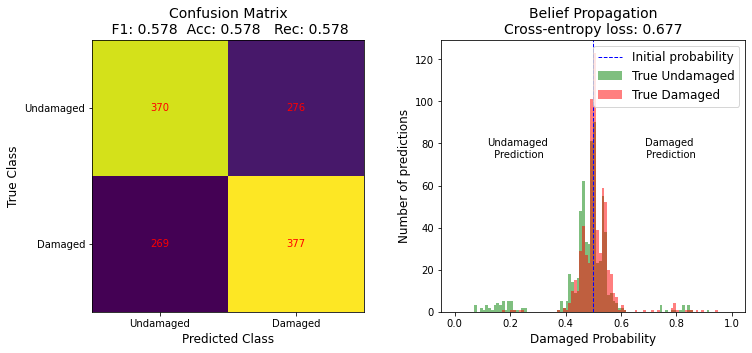

In [361]:
plots = evaluate_output(output)

Want to save the plot? Run the cell below. If you want to specify a location replace the False boolean with the filepath.

In [362]:
df.save_plot(plots, location=False)

In [7]:
import geopandas as gpd
import helper_functions as hf
import netconf as nc
def run_bp(v, limit=1e-5):
    # Retrieve data from inputs
    for i in v.keys(): globals()[i] = v[i]
    initial = v['initial']
    trainSplit = bxNodes.trait_values()['children'][3].value
    confidence = list(bxConf.trait_values()['children'][1].value)
    neighbours = [i.value for i in bxEdges.trait_values()['children'][1].trait_values()['children']]
    adjacent, geoNeighbours = [i.value for i in bxAdjacent.trait_values()['children'][1::2]]

    # Split pixels in to train and test sets    
    X_train, X_test, y_train, y_test = hf.train_test_split(labelsUsed, cn, hf.get_polygon(testPoly, conv=True), testSplit=(1-(trainSplit/100)))
    
    # Create nodes
    nodes = hf.create_nodes(initial, X_train)

    import numpy as np
    summary = nodes.groupby(cn).size()
    equivUse = True
    if equivUse:
        equiv = gpd.GeoDataFrame()
        for i in summary.index.values:
            equiv = equiv.append(nodes[nodes[cn] == i][0:min(summary)])
        equiv = equiv.append(nodes[[np.isnan(x) for x in nodes[cn]]])
        nodes=equiv.copy()
        initial = initial.loc[nodes.index.values].reset_index()
    
    # Assign prior beliefs from assessments
    priors = hf.prior_beliefs(nodes, beliefColumns = initial.columns[-nClasses:], beliefs=confidence, classNames=classNames, column = cn)
    
    if all(values is 0 for values in neighbours) and (geoNeighbours is 0):
        edges, beliefs = [], priors
    else:
        # Create edges
        edges = hf.create_edges(nodes, adjacent=adjacent, geo_neighbours=geoNeighbours, values=typesUsed, neighbours=neighbours)

        # Run belief propagation
        beliefs, _ = nc.netconf(edges,priors,verbose=True,limit=limit)
    
    v.update({'trainSplit':trainSplit, 'confidence':confidence, 'neighbours':neighbours, 'adjacent':adjacent, 'geoNeighbours':geoNeighbours, 'X_train':X_train, 'X_test':X_test, 'nodes':nodes, 'priors':priors, 'edges':edges,'beliefs':beliefs,'initial':initial})
    return v

In [21]:
import sklearn as skl
import plotting as pl
def evaluate_output(v):
    for i in v.keys(): globals()[i] = v[i]
    # Get y_true vs y_pred for test set
    y_true, y_pred = get_labels(initial, X_test, beliefs, column=cn)
    
    # Classification metrics
    true_clf, pred_clf = hf.class_metrics(y_true, y_pred, classes=usedNames, orig=unique)

    fig, axs = pl.create_subplots(1,2, figsize=[12,5])
    
    # Confusion matrix
    axs = pl.confusion_matrix(axs, true_clf, pred_clf, usedNames)

    # Cross entropy / Confidence metrics
    if nClasses == 2: axs = cross_entropy_metrics(axs, y_true, y_pred[:,1].reshape(-1,1), usedNames)
    else: axs[1] = pl.cross_entropy_multiclass(axs[1], true_clf, y_pred, usedNames)

    pl.show_plot()
    
    v.update({'y_true':y_true, 'y_pred':y_pred, 'true_clf':true_clf, 'pred_clf':pred_clf, 'fig':fig})
    
    return v

def cross_entropy_metrics(axs, y_true, y_pred, classes, dmgThresh=0.5, initBelief=0.5):
    try: ax = axs[1]
    except: ax = axs
    try: 
        int(classes[0]), int(classes[1])
        label1, label2 = 'True class '+str(classes[0]), 'True class '+str(classes[1])
    except: label1, label2 = 'True '+str(classes[0]), 'True '+str(classes[1])
    p1 = ax.hist(y_pred[(np.array(1-y_true)*y_pred).nonzero()[0]], range = [0,1], bins = 100, label = label1, color = 'g', alpha = 0.5) 
    if len(classes) > 1:
        p2 = ax.hist(y_pred[(np.array(y_true)*y_pred).nonzero()[0]], range = [0,1], bins = 100, label =  label2, color = 'r', alpha = 0.5)
#   ax.axvline(x=dmgThresh, color='k',linestyle='--', linewidth=1, label='Classification Threshold')
    ax.axvline(x=initBelief, color='b',linestyle='--', linewidth=1, label='Initial probability')
    log_loss = skl.metrics.log_loss(y_true, y_pred, labels=[0,1])
    ax.set_title('Belief Propagation\nCross-entropy loss: {:.3f}'.format(log_loss),size=14)
    ax.legend(loc='best',fontsize=12), 
    try: 
        int(classes[0]), int(classes[1])
        ax.set_xlabel('Class '+str(classes[1])+' Probability',fontsize=12)
        ax.text(dmgThresh/2, 0.6, 'Class '+str(classes[0])+'\n Prediction', ha='center', va='center', transform=ax.transAxes,fontsize=12)
        ax.text(dmgThresh+(1-dmgThresh)/2, 0.6, 'Class '+str(classes[1])+'\n Prediction', ha='center', va='center', transform=ax.transAxes,fontsize=12)
    except:
        ax.set_xlabel(str(classes[1])+' Probability',fontsize=12)
        ax.text(dmgThresh/2, 0.6, str(classes[0])+'\n Prediction', ha='center', va='center', transform=ax.transAxes)
        ax.text(dmgThresh+(1-dmgThresh)/2, 0.6, str(classes[1])+'\n Prediction', ha='center', va='center', transform=ax.transAxes)
    ax.set_ylabel('Number of predictions',fontsize=12)
    return axs, log_loss
  
# Get y_true and y_pred for test set oof nodes
def get_labels(init, X_test, beliefs, column, values = False):
    gdf = gpd.sjoin(init, X_test, how='left', op='within').dropna(subset=[column])
    summary = gdf.groupby(cn).size()
    equivTest = True
    if equivTest:
        equiv = gpd.GeoDataFrame()
        for i in summary.index.values:
            equiv = equiv.append(gdf[gdf[cn] == i][0:min(summary)])
        equiv = equiv.append(gdf[[np.isnan(x) for x in gdf[cn]]])
        y_true = equiv[column]
    else: y_true = gdf[column]

    if values: y_true = y_true.map(values)
    y_pred = skl.preprocessing.normalize(beliefs[y_true.index], norm='l1')
    return np.array(y_true).reshape(-1,1).astype(type(y_true.values[0])), y_pred

In [9]:
import demo_functions as demo
import imports as ip
def import_data(v):
    # Retrieve file locations from inputs
    v['dataTypes'] = [i.value.split(' ')[0] for i in v['bxDataTypes'].trait_values()['children'][1:] if len(i.value) > 0]
    for j in range(len(v['dataTypes'])):
        try: v['preFile'+str(j)], v['postFile'+str(j)] = [i.value for i in v['bxfile'+str(j)].trait_values()['children'][1::2]]    
        except KeyError: raise KeyError('Please make sure you have confirmed the data types.')
    for i in v.keys(): globals()[i] = v[i] # Retrieve variables to use
   
    # Reproject Data if necessary
    v = demo.reproject_data(v)
    
    # Import Files
    print("------Importing Data Files---------")
    # Import first data type
    df, crop = ip.img_to_df(postFile0, testPoly, crs=crs)
    if preFile0:
        preDf, _ = ip.img_to_df(preFile0, testPoly, crs=crs)
        df -= preDf

    # Import other data types
    if len(dataTypes) > 1:
        crop.rio.to_raster("croptemp.tif")
        for i in range(1, len(dataTypes)):
            ip.resample_tif(globals()['postFile'+str(i)], testPoly, 'posttemp'+str(i)+'.tif')
            globals()['dataArray'+str(i)] = ip.tif_to_array('posttemp'+str(i)+'.tif', 'resample')
            if globals()['preFile'+str(i)]: 
                ip.resample_tif(globals()['preFile'+str(i)], testPoly, 'pretemp'+str(i)+'.tif')
                globals()['dataArray'+str(i)] -= ip.tif_to_array('pretemp'+str(i)+'.tif', 'resample')
        ip.del_file_endings(".", "temp*.tif")

    # Concatenate data types
    data = df.copy()
    for j in range(1, len(dataTypes)): data[dataTypes[j]]=globals()['dataArray'+str(j)].flatten()
    data.dropna(inplace=True)
    print("------Finished Data Import---------")
    typesUsed = [list(df.columns.values)]
    for j in range(1,len(dataTypes)): typesUsed.append(list(data.columns[[dataTypes[j] in str(i) for i in data.columns]]))

    v.update({'data':data, 'typesUsed':typesUsed})
    return v

In [260]:
output['initial'].loc[output['nodes'].index.values].reset_index()

,index,0,1,2,Interferogram,geometry,GREEN,RED
0,1,110.0,150.0,70.0,-1.466011,POINT (33.89367274474693 35.51889501388001),0.5,0.5
1,3,-107.0,-141.0,-67.0,4.183954,POINT (33.89782075593958 35.51336928809768),0.5,0.5
2,19,-23.0,-3.0,13.0,4.198683,POINT (33.89767208170329 35.51365672495452),0.5,0.5
3,20,76.0,103.0,59.0,0.515863,POINT (33.89817261829882 35.52704236202903),0.5,0.5
4,36,1.0,5.0,9.0,-2.065124,POINT (33.89540727750371 35.51834491920572),0.5,0.5
...,...,...,...,...,...,...,...,...
8718,9995,-59.0,-63.0,-34.0,0.332645,POINT (33.89398496064315 35.52558039870545),0.5,0.5
8719,9996,-5.0,1.0,13.0,-4.981379,POINT (33.893107782649 35.51817642173791),0.5,0.5
8720,9997,15.0,20.0,8.0,3.089128,POINT (33.89872766878099 35.51420681962881),0.5,0.5
8721,9998,-3.0,6.0,3.0,0.742297,POINT (33.89813297183581 35.52741404761976),0.5,0.5


In [246]:
import ipyleaflet as ipl
import sys
# Converting gdf columns to GeoData for plotting
def to_geodata(gdf, color, name='Data', fill=0.7):
    plotGdf = ipl.GeoData(geo_dataframe = gdf,
                          style={'color': color, 'radius':2, 'fillColor': color, 'opacity':fill+0.1, 'weight':1.9, 'dashArray':'2', 'fillOpacity':fill},
                          hover_style={'fillColor': 'white' , 'fillOpacity': 0.2},
                          point_style={'radius': 3, 'color': color, 'fillOpacity': 0.8, 'fillColor': color, 'weight': 3},
                          name = name)
    return plotGdf

# Plotting for building footprints with attached assessments
def plot_assessments(gdf, mapName, cn='decision', classes=['GREEN','YELLOW','RED','TOTAL','LAND'], colors=['green','yellow','red','maroon','cyan'],
                     layer_name='Data', layer_only=False, no_leg=False, fill=0.7, legName=False):
    classes = inputs['labels']['decision'].unique() if classes is False else classes 
    leg = {}
    globals()['layer'+layer_name] = ipl.LayerGroup(name = layer_name)
    for i, cl in enumerate(classes):
        try: globals()['layer'+layer_name].add_layer(to_geodata(gdf.loc[gdf[cn].str.contains(cl)],colors[i],layer_name,fill))
        except: globals()['layer'+layer_name].add_layer(to_geodata(gdf.loc[gdf[cn] == cl],colors[i],layer_name,fill))
        leg.update({cl:colors[i]})
    if not layer_only:
        mapName.add_layer(globals()['layer'+layer_name])
        if not 'l1' in globals() and no_leg is False: # Add legend if forming map for first time
            l1 = ipl.LegendControl(leg, name=cn if legName is False else legName, position="bottomleft")
            mapName.add_control(l1)
        return mapName
    else: return globals()['layer'+layer_name]

In [372]:
# Visualise spatial results
import plotting as pl
for i in plots.keys(): globals()[i] = plots[i] # Retrieve variables to use
from ipyleaflet import LayersControl
import ipywidgets as ipw
from branca.colormap import linear
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
ngrid=100

mf = pl.create_map(lat, lon, zoom, basemap=ipl.basemaps.OpenStreetMap.BlackAndWhite)

plot_assessments(labels, mf, cn=cn, layer_name='Ground truth', fill=0.4, legName='Ground Truth')

plot_assessments(nodes.to_crs({'init':crs}).dropna(), mf, layer_name='Train Locations', no_leg=True, classes=sorted([x for x in nodes.decision.unique() if str(x) != 'nan']), colors = ['green', 'red'] if nClasses==2 else None)



import geopandas as gpd
a = gpd.sjoin(initial, X_test, how='left', op='within').dropna(subset=[cn])
a['prediction']=pred_clf
plot_assessments(a.to_crs({'init':crs}).dropna(), mf, cn='prediction', layer_name='Test Predictions', no_leg=True, classes=[x for x in a.prediction.unique() if str(x) != 'nan'], colors = ['green', 'red'] if nClasses==2 else None)

from scipy.interpolate import griddata
xi, yi = np.linspace(nodes.geometry.x.min(), nodes.geometry.x.max(), ngrid), np.linspace(nodes.geometry.y.min(), nodes.geometry.y.max(), ngrid)
zi = griddata((nodes.geometry.x, nodes.geometry.y), (beliefs[:,0]-beliefs[:,1]+0.5), (xi[None, :], yi[:, None]), method='nearest')
#cs = plt.contourf(xi, yi, zi, norm=matplotlib.colors.Normalize(vmin=zi.min(), vmax=zi.max()),levels=20)
levs = math.floor((zi.max()-zi.min())/0.1)
print(levs)
cs = plt.contourf(xi, yi, zi, levels=levs-1, extend='both')
plt.close() 
        
# add contours as polygons
# hardwired colors for now: these correspons to the 8-level default of matplotlib with an added orange color
# add contours as polygons
# hardwired colors for now: these correspons to the 8-level default of matplotlib with an added orange color
# colors10 = ["#ff0000", "#ff3232", "#ff6666", "#ff9999", "#ffcccc", "#ccf5cc", "#99eb99", "#66e166", "#32d732","#00cd00"]
# colors20 = ["#ff0000","#ff0000", "#ff1919", "#ff3232","#ff4c4c", "#ff6666", "#ff7f7f", "#ff9999","#ffb2b2", "#ffcccc","#ccf5cc","#ccf5cc","#ccf5cc","#ccf5cc","#ccf5cc","#b2f0b2", "#99eb99","#7fe67f","#66e166","#4cdc4c","#32d732","#19d219","#00cd00","#00cd00"]
#"#ffe5e5","#ffffff","#e5fae5"
colorsRed = ['#e50000','#ff0000','#ff3232','#ff6666','#ff9999']
colorsGreen = ['#b2f0b2','#99eb99','#66e166','#32d732','#00b800']
colors=[]
print(len(cs.allsegs))
for i in range(math.floor(len(cs.allsegs)/2-5)-math.floor(((zi.max()-1-(0-zi.min()))/0.1)/2)): colors.append('#ff0000')
colors += colorsRed
colors += colorsGreen
for i in range(math.ceil(len(cs.allsegs)/2-5)+math.floor(((zi.max()-1-(0-zi.min()))/0.1)/2)): colors.append('#32d732')
allsegs, allkinds = cs.allsegs, cs.allkinds
print(colors)
contourLayer = ipl.LayerGroup(name = 'Assessment Contours')
for clev in range(len(cs.allsegs)):
    print(clev)
    kinds = None if allkinds is None else allkinds[clev]
    segs = split_contours(allsegs[clev], kinds)
    polygons = ipl.Polygon(
                    locations=[p.tolist() for p in segs],
                    # locations=segs[14].tolist(),
                    color=colors[clev],
                    weight=1,
                    opacity=0.5,
                    fill_color=colors[clev],
                    fill_opacity=0.4,
                    name='layer_name'
    )
    contourLayer.add_layer(polygons)

mf.add_layer(contourLayer)

control = ipl.LayersControl(position='topright')

leg = dict(zip([str(round(x-0.1,1))+'-'+str(round(x,1)) for x in np.linspace(1,0.1,10).tolist()],colorsRed+colorsGreen))
l2 = ipl.LegendControl(leg, name='Damage Prob', position="topleft")
mf.add_control(l2)

mf.add_control(control)

zoom_slider = ipw.IntSlider(description='Zoom level:', min=7, max=18, value=14)
ipw.jslink((zoom_slider, 'value'), (mf, 'zoom'))
widget_control1 = ipl.WidgetControl(widget=zoom_slider, position='topright')
mf.add_control(widget_control1)
mf.add_control(ipl.FullScreenControl(position='topright'))
mf.zoom_control = False
mf


32
22
['#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ff0000', '#e50000', '#ff0000', '#ff3232', '#ff6666', '#ff9999', '#b2f0b2', '#99eb99', '#66e166', '#32d732', '#00b800', '#32d732', '#32d732', '#32d732', '#32d732', '#32d732', '#32d732', '#32d732']
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


Map(center=[33.893, 35.512], controls=(AttributionControl(options=['position', 'prefix'], position='bottomrigh…

In [248]:
def split_contours(segs, kinds=None):
    """takes a list of polygons and vertex kinds and separates disconnected vertices into separate lists.
    The input arrays can be derived from the allsegs and allkinds atributes of the result of a matplotlib
    contour or contourf call. They correspond to the contours of one contour level.
    
    Example:
    cs = plt.contourf(x, y, z)
    allsegs = cs.allsegs
    allkinds = cs.allkinds
    for i, segs in enumerate(allsegs):
        kinds = None if allkinds is None else allkinds[i]
        new_segs = split_contours(segs, kinds)
        # do something with new_segs
        
    More information:
    https://matplotlib.org/3.3.3/_modules/matplotlib/contour.html#ClabelText
    https://matplotlib.org/3.1.0/api/path_api.html#matplotlib.path.Path
    """
    if kinds is None:
        return segs    # nothing to be done
    # search for kind=79 as this marks the end of one polygon segment
    # Notes: 
    # 1. we ignore the different polygon styles of matplotlib Path here and only
    # look for polygon segments.
    # 2. the Path documentation recommends to use iter_segments instead of direct
    # access to vertices and node types. However, since the ipyleaflet Polygon expects
    # a complete polygon and not individual segments, this cannot be used here
    # (it may be helpful to clean polygons before passing them into ipyleaflet's Polygon,
    # but so far I don't see a necessity to do so)
    new_segs = []
    for i, seg in enumerate(segs):
        segkinds = kinds[i]
        boundaries = [0] + list(np.nonzero(segkinds == 79)[0])
        for b in range(len(boundaries)-1):
            new_segs.append(seg[boundaries[b]+(1 if b>0 else 0):boundaries[b+1]])
    return new_segs

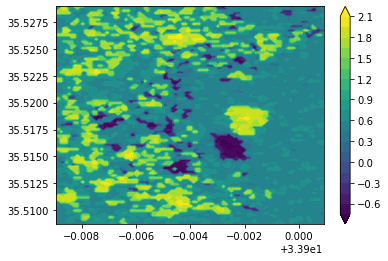

In [312]:
#contour = plt.contourf(xi, yi, zi, levels=14, cmap='RdYlGn')
import math
cs = plt.contourf(xi, yi, zi, levels=28, extend='both')
plt.colorbar()

In [13]:
def classify_data(v,seed=1):
    # Retrieve data from inputs
    for i in v.keys(): globals()[i] = v[i]
    max_nodes = bxNodes.trait_values()['children'][1].value
    nClasses = bxNClasses.trait_values()['children'][1].value
    classAssign = False if ('bxAssign' not in v) or (bxCluster.trait_values()['children'][1].value is True) else [list(i.value) for i in bxAssign.trait_values()['children']]
    classNames = False if 'bxClNames' not in v else [i.value for i in bxClNames.trait_values()['children']]

    # Sample data and create geodataframe
    print("------Data Sampling---------")
    if max_nodes < 2: raise ValueError("Insufficient Nodes for belief propagation")
    gdf = ip.get_sample_gdf(data, max_nodes, crs,seed=1)
   
    print("------Data Classification---------")
    
    defClasses, labelsUsed, dataUsed = len(labels[cn].unique()), labels.to_crs(crs).copy(), gdf.copy() # Default classes from labels
    usedNames = labels[cn].unique() if nClasses==defClasses or nClasses is False else classNames
    initial = hf.init_beliefs(dataUsed, classes=nClasses, columns=usedNames, crs=crs) # Initial class value for each data pixel

    if not nClasses or nClasses == defClasses: 
        nClasses = defClasses # If default classes used
        classesUsed = usedNames.copy()
    elif nClasses > defClasses: raise NameError('Cannot assign more classes than in original data') # If invalid input
    elif nClasses < defClasses: # Perform class grouping
        items = [item for sublist in classAssign for item in sublist] if classAssign is not False else False
        if (classAssign is False) or not any(classAssign) or (len(items) is not (len(set(items)))): # Perform clustering
            if classAssign is not False: print('Incorrect class assignment - Proceeding with clustering. Please assign a single class for each value.')
            # Assign labels to each pixel
            allPixels = hf.create_nodes(initial, labelsUsed[['geometry',cn]][labelsUsed.within(hf.get_polygon(testPoly, conv=True))])
            # Run PCA if set to True
            #X = hf.run_PCA(dataUsed[typesUsed[0]].values.transpose(), pcaComps).components_.transpose() if pca else dataUsed[typesUsed[0]]
            types = [item for sublist in typesUsed for item in sublist]
            X = dataUsed[types]
            # Run clustering
            meanCluster = True
            kmeans, clusterClasses, initLabels = hf.run_cluster(X.iloc[allPixels[cn].dropna().index].values.reshape(-1,len(types)), allPixels[cn].dropna(), meanCluster, nClasses)
            print('Clustered classes:{} , original classes:{}'.format(clusterClasses, initLabels))
            # Create groups of classes
            classesUsed = []
            for j in range(nClasses): classesUsed.append([initLabels[i] for i, x in enumerate(list(clusterClasses)) if x==j])
        
        else:
            if len(set(items)) is not defClasses:
                print('Not all labels have been assigned to class. Sampling data to include only labels selected.')
                labelsUsed = labelsUsed.loc[labelsUsed[cn].isin(items)]
            classesUsed = classAssign
            #used = [i in flatten_list(classesUsed) for i in labelsUsed[cn]]
            initial = hf.init_beliefs(dataUsed, classes=nClasses, columns=usedNames, crs=crs)

        # Assign labels for each pixel after clustering
        labelsUsed[cn] = hf.group_classes(labelsUsed[cn], classesUsed)
    print("------Finished Data Classification---------") 

    # Update variables
    v.update({'max_nodes':max_nodes, 'nClasses':nClasses, 'classAssign':classAssign,'classNames':classNames, 'labelsUsed':labelsUsed,'initial':initial, 'usedNames':usedNames, 'classesUsed':classesUsed, 'dataUsed':dataUsed})
    return v

In [31]:
# Visualise spatial results
import plotting as pl
for i in plots.keys(): globals()[i] = plots[i] # Retrieve variables to use
from ipyleaflet import LayersControl
import ipywidgets as ipw

mf = pl.create_map(lat, lon, zoom, basemap=ipl.basemaps.OpenStreetMap.BlackAndWhite)

plot_assessments(labels, mf, cn=cn, layer_name='Ground truth', fill=0.1)

plot_assessments(nodes.to_crs({'init':crs}).dropna(), mf, layer_name='Train Locations', no_leg=True)

import geopandas as gpd
a = gpd.sjoin(initial, X_test, how='left', op='within').dropna(subset=[cn])
a['prediction']=pred_clf
plot_assessments(a.to_crs({'init':crs}).dropna(), mf, cn='prediction', layer_name='Test Predictions', no_leg=True)

control = ipl.LayersControl(position='topright')

mf.add_control(control)

zoom_slider = ipw.IntSlider(description='Zoom level:', min=7, max=18, value=14)
ipw.jslink((zoom_slider, 'value'), (mf, 'zoom'))
widget_control1 = ipl.WidgetControl(widget=zoom_slider, position='topright')
mf.add_control(widget_control1)
mf.add_control(ipl.FullScreenControl())
mf

Map(center=[33.893, 35.512], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…